In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import torch
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from statsmodels.stats import multitest
import umap

from MPCCA.py import mcfa
from scipy import stats

torch.set_printoptions(linewidth = 200)
np.set_printoptions(linewidth = 200, precision=3)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', 100)

In [2]:
exam = '1'
# exam = '5'

methyl_data_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/methyl_cca_collated_exam' + exam + '.csv.gz'
metab_data_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/metab_cca_collated_exam' + exam + '.csv.gz'
exp_data_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/exp_cca_collated_exam' + exam + '.csv.gz'
protein_data_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/protein_cca_collated_exam' + exam + '.csv.gz'
meta_df_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/metadata_cca_collated_exam' + exam + '.csv'
probe_gene_map_fn='/gpfs/commons/projects/MESA/projects/mpcca/methyl_probe_gene_map.txt'

factor_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/factors_exam' + exam + '.csv'
gsea_perm_save_prefix='/gpfs/commons/projects/MESA/projects/mpcca/gsea_perm_exam' + exam

factor_cv_fn = '/gpfs/commons/projects/MESA/projects/mpcca/factors_cv_exam' + exam + '.csv'
nrmse_tr_fn = '/gpfs/commons/projects/MESA/projects/mpcca/nrmse_tr_cv_exam' + exam + '.csv'
nrmse_te_fn = '/gpfs/commons/projects/MESA/projects/mpcca/nrmse_te_cv_exam' + exam + '.csv'

In [3]:
meta_df = pd.read_csv(meta_df_save_fn, index_col=0)

In [4]:
meta_df.columns[meta_df.isna().sum() > 400]

Index(['exclusion_reason', 'hba1c', 'cd40', 'eselectin', 'mmp9',
       'years_drinking_former'],
      dtype='object')

In [5]:
# These all have too many missing values, perfect correlation with something else,
# are just sample identifiers, or we were told to exclude by collaborators.
ignore_cols = ['Metabolomics', 'Methylomics', 'Proteomics', 'Transcriptomics_PBMC',
               'adapter_contam_pct', 'lc_sets', 'original_blood_draw_tube', 'rna_isolation_method',
               'analysis_freeze', 'exclusion_reason', 'Sample_Well', 'Sample_Plate',
               'Sentrix_ID', 'Batch', 'LEVEL1.batch', 'hba1c', 'cimt_1', 'cimt_2', 'carotid_stenosis',
               'smoking_quit_smoking', 'num_nans', 'cd40', 'eselectin', 'mmp9', 'years_drinking_former',
               'PM25', 'NOx', 'NO2', 'O3']

In [6]:
meta_df = meta_df.drop(ignore_cols, axis=1)
meta_df['month'] = meta_df['month'].astype('str')
meta_df['edu_cat'] = meta_df['edu_cat'].astype('str')
meta_df['season'] = meta_df['season'].astype('str')
meta_df['SRA'] = meta_df['Race']
meta_df['WHtR'] = meta_df['waist_cm']/meta_df['ht_cm']
meta_df = meta_df.drop('Race', axis=1)
meta_df_dummies = pd.get_dummies(meta_df, )
meta_df_dummies.column_2 = meta_df_dummies.column_2.astype('uint8')
meta_df_dummies.column_3 = meta_df_dummies.column_3.astype('uint8')

In [ ]:
metab_data = pd.read_csv(metab_data_save_fn, index_col=0).T
protein_data = pd.read_csv(protein_data_save_fn, index_col=0).T
exp_data = pd.read_csv(exp_data_save_fn, index_col=0).T
methyl_data = pd.read_csv(methyl_data_save_fn, index_col=0).T

In [ ]:
# Drop the .X from the ENSGs for compatability with the annot later.
exp_data.columns = [col_name[0] for col_name in exp_data.columns.str.split('.')]
protein_data.columns = [col_name[0] for col_name in protein_data.columns.str.split('.')]

In [ ]:
print(meta_df.shape, metab_data.shape, protein_data.shape, exp_data.shape, methyl_data.shape)

(614, 92) (614, 6042) (614, 1222) (614, 19034) (614, 724210)


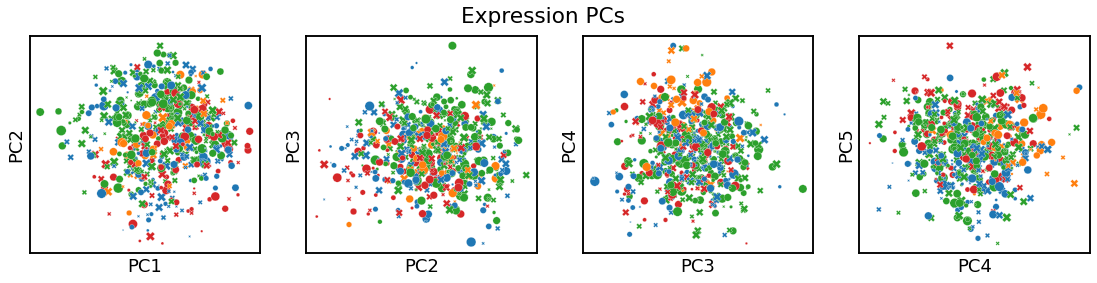

In [ ]:
# Quick visualization of the top PCs of individual modes.

sns.set_context('talk')
figure, axes = plt.subplots(1, 4, sharex=False, figsize=(19,4))
figure.suptitle('Expression PCs')

for ax, x, y in zip(axes, ['PC1', 'PC2', 'PC3', 'PC4'], ['PC2', 'PC3', 'PC4', 'PC5']):
    ax.yaxis.labelpad = -8
    ax.xaxis.labelpad = -8
    ax.set(xticklabels=[], yticklabels=[])
    ax.tick_params(bottom=False, left=False)
    sns.scatterplot(ax=ax, data=mcfa_res.data_pcs['exp'].pcs, x=x, y=y, sizes=(1,100),
                    hue=meta_df['SRA'], style=meta_df['Sex'], size=meta_df['Age'], legend=False)
figure.show()

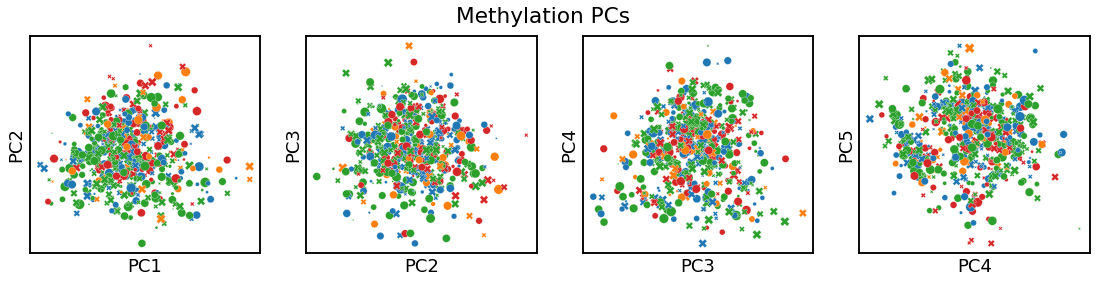

In [ ]:
sns.set_context('talk')
figure, axes = plt.subplots(1, 4, sharex=False, figsize=(19,4))
figure.suptitle('Methylation PCs')

for ax, x, y in zip(axes, ['PC1', 'PC2', 'PC3', 'PC4'], ['PC2', 'PC3', 'PC4', 'PC5']):
    ax.yaxis.labelpad = -8
    ax.xaxis.labelpad = -8
    ax.set(xticklabels=[], yticklabels=[])
    ax.tick_params(bottom=False, left=False)
    sns.scatterplot(ax=ax, data=mcfa_res.data_pcs['methyl'].pcs, x=x, y=y, sizes=(1,100),
                    hue=meta_df['SRA'], style=meta_df['Sex'], size=meta_df['Age'], legend=False)
figure.show()

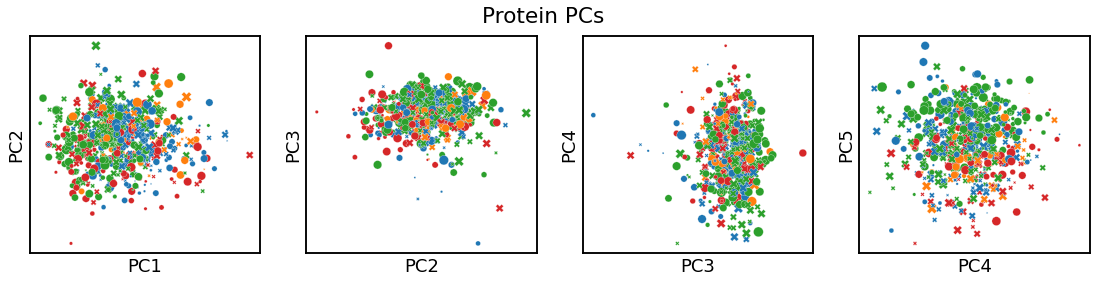

In [ ]:
sns.set_context('talk')
figure, axes = plt.subplots(1, 4, sharex=False, figsize=(19,4))
figure.suptitle('Protein PCs')

for ax, x, y in zip(axes, ['PC1', 'PC2', 'PC3', 'PC4'], ['PC2', 'PC3', 'PC4', 'PC5']):
    ax.yaxis.labelpad = -8
    ax.xaxis.labelpad = -8
    ax.set(xticklabels=[], yticklabels=[])
    ax.tick_params(bottom=False, left=False)
    sns.scatterplot(ax=ax, data=mcfa_res.data_pcs['prot'].pcs, x=x, y=y, sizes=(1,100),
                    hue=meta_df['SRA'], style=meta_df['Sex'], size=meta_df['Age'], legend=False)
figure.show()

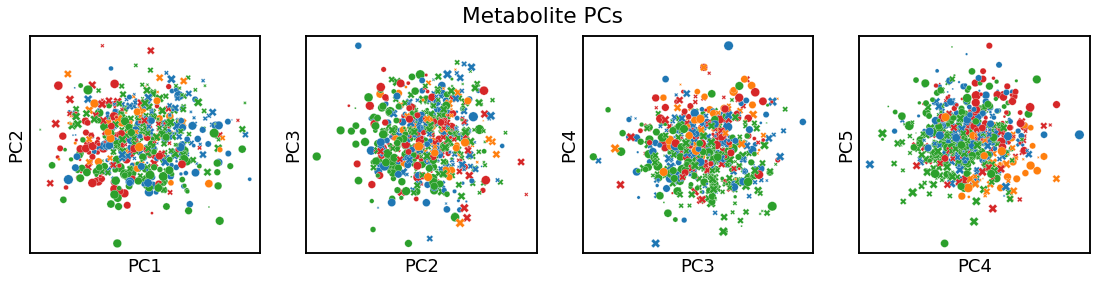

In [ ]:
sns.set_context('talk')
figure, axes = plt.subplots(1, 4, sharex=False, figsize=(19,4))
figure.suptitle('Metabolite PCs')

for ax, x, y in zip(axes, ['PC1', 'PC2', 'PC3', 'PC4'], ['PC2', 'PC3', 'PC4', 'PC5']):
    ax.yaxis.labelpad = -8
    ax.xaxis.labelpad = -8
    ax.set(xticklabels=[], yticklabels=[])
    ax.tick_params(bottom=False, left=False)
    sns.scatterplot(ax=ax, data=mcfa_res.data_pcs['metab'].pcs, x=x, y=y, sizes=(1,100),
                    hue=meta_df['SRA'], style=meta_df['Sex'], size=meta_df['Age'], legend=False)
figure.show()

In [ ]:
Y = {'exp': exp_data, 'methyl': methyl_data, 'prot': protein_data, 'metab': metab_data}

In [ ]:
%%time
mcfa_res = mcfa.mcfa(Y)

Calculating data PCs.
Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 14 components above rho inclusion threshold 1.935603141784668.
Fitting the model.
iter: 0 Likelihood: 372523.73275848804
Iter: 1 Likelihood: 371216.7421666188 Percent change: 0.0035208287865491463 Time (s): 0.05185413360595703
Iter: 2 Likelihood: 370916.7302093358 Percent change: 0.0008088391082108817 Time (s): 0.06554961204528809
Iter: 3 Likelihood: 370799.48262864054 Percent change: 0.00031620211512722553 Time (s): 0.07724952697753906
Iter: 4 Likelihood: 370728.4867455786 Percent change: 0.00019150371660185006 Time (s): 0.08811140060424805
Iter: 5 Likelihood: 370677.1169189131 Percent change: 0.00013858375475801145 Time (s): 0.10352444648742676
Iter: 6 Likelihood: 370637.37005934305 Percent change: 0.00010723921218108671 Time (s): 0.1131596565246582
Iter: 7 Likelihood: 370605.36880631145 Percent change: 8.634859536621121e-05 Time (s): 0.1228477954864502
Iter: 8 L

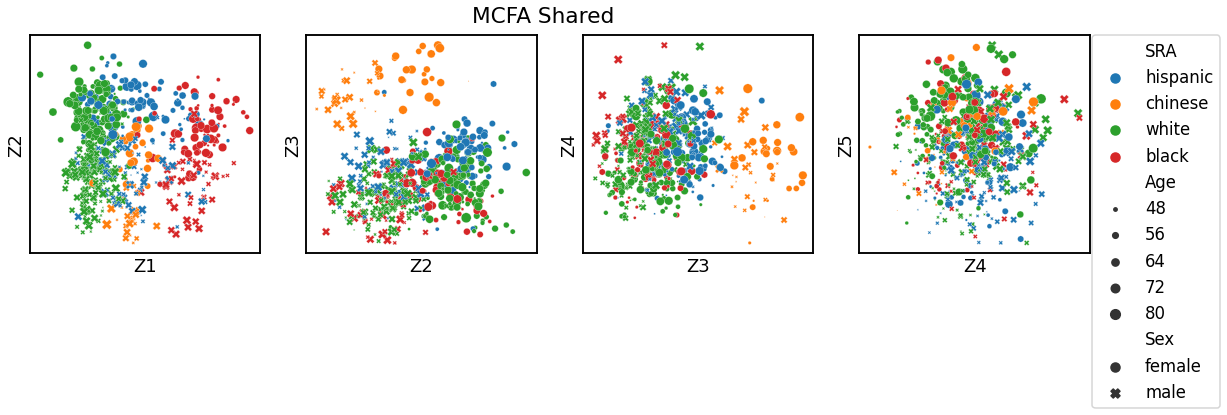

In [ ]:
sns.set_context('talk')
figure, axes = plt.subplots(1, 4, sharex=False, figsize=(19,4))
figure.suptitle('MCFA Shared')

for ax, x, y in zip(axes, ['Z1', 'Z2', 'Z3', 'Z4'], ['Z2', 'Z3', 'Z4', 'Z5']):
    # ax.set_title(x + ' vs ' + y)
    ax.set(xticklabels=[], yticklabels=[])
    ax.yaxis.labelpad = -8
    ax.xaxis.labelpad = -8
    ax.tick_params(bottom=False, left=False)
    sns.scatterplot(ax=ax, data=mcfa_res.Z, x=x, y=y, sizes=(1,100),
                    hue=meta_df['SRA'], style=meta_df['Sex'], size=meta_df['Age'],
                    legend=True if y=='Z5' else False)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0.)
figure.show()

In [ ]:
mcfa_res_df = pd.concat([mcfa_res.Z] + list(mcfa_res.X.values()), axis=1)
mcfa_res_df.to_csv(factor_save_fn)

In [ ]:
mcfa_res.var_exp_Z.columns = ['Expression', 'Methylation', 'Protein', 'Metabolite']
var_exp_private = [ve_L.sum() for ve_L in mcfa_res.var_exp_L]
var_exp_shared = mcfa_res.var_exp_Z.sum()
var_exp_totals = pd.DataFrame({'Shared': var_exp_shared, 'Private': var_exp_private})
var_exp_totals['Total'] = var_exp_totals['Shared'] + var_exp_totals['Private'] 
var_exp_normed = (mcfa_res.var_exp_Z/var_exp_totals['Total']).T
var_exp_totals['Residual'] = 1 - var_exp_totals['Total']
var_exp_totals = var_exp_totals.drop('Total', axis=1)

In [ ]:
var_exp_totals['dataset'] = var_exp_totals.index
var_exp_totals = var_exp_totals.melt(id_vars=['dataset'], var_name='Space', value_name='Variance explained')

In [ ]:
var_exp_totals

dataset     Space  Variance explained
0    Expression    Shared            0.166206
1   Methylation    Shared            0.080654
2       Protein    Shared            0.291591
3    Metabolite    Shared            0.170819
4    Expression   Private            0.367563
5   Methylation   Private            0.334344
6       Protein   Private            0.130075
7    Metabolite   Private            0.320008
8    Expression  Residual            0.466232
9   Methylation  Residual            0.585002
10      Protein  Residual            0.578334
11   Metabolite  Residual            0.509174

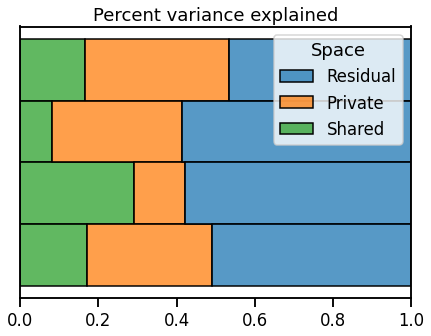

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(7, 5))
var_exp_totals['Space'] = pd.Categorical(var_exp_totals['Space'], ['Residual', 'Private', 'Shared'])
ax = sns.histplot(var_exp_totals, y='dataset', hue='Space', weights='Variance explained',
             multiple='stack')
ax.set(title='Percent variance explained', xlabel=None, ylabel=None)
ax.set_xlim(0, 1)
ax.tick_params(left=False)
ax.set(yticklabels=[])
plt.show()

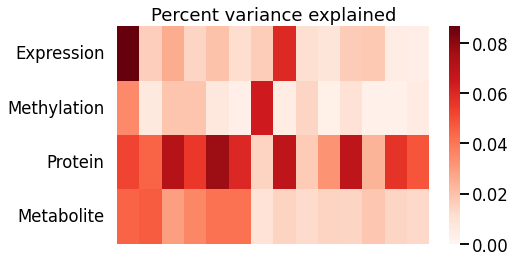

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(7, 4))
ax = sns.heatmap(var_exp_normed, vmin=0, cmap='Reds')
ax.set(xlabel=None, title='Percent variance explained', xticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.show()

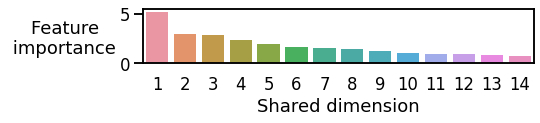

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(7, 1))
ax = sns.barplot(x=mcfa_res.rho.index, y=mcfa_res.rho)
ax.set_ylabel('Feature   \n importance', rotation=0, y=0.1, ha='right')
ax.tick_params(bottom=False)
ax.set(xticklabels=range(1, 15))
ax.set(xlabel='Shared dimension')
plt.show()

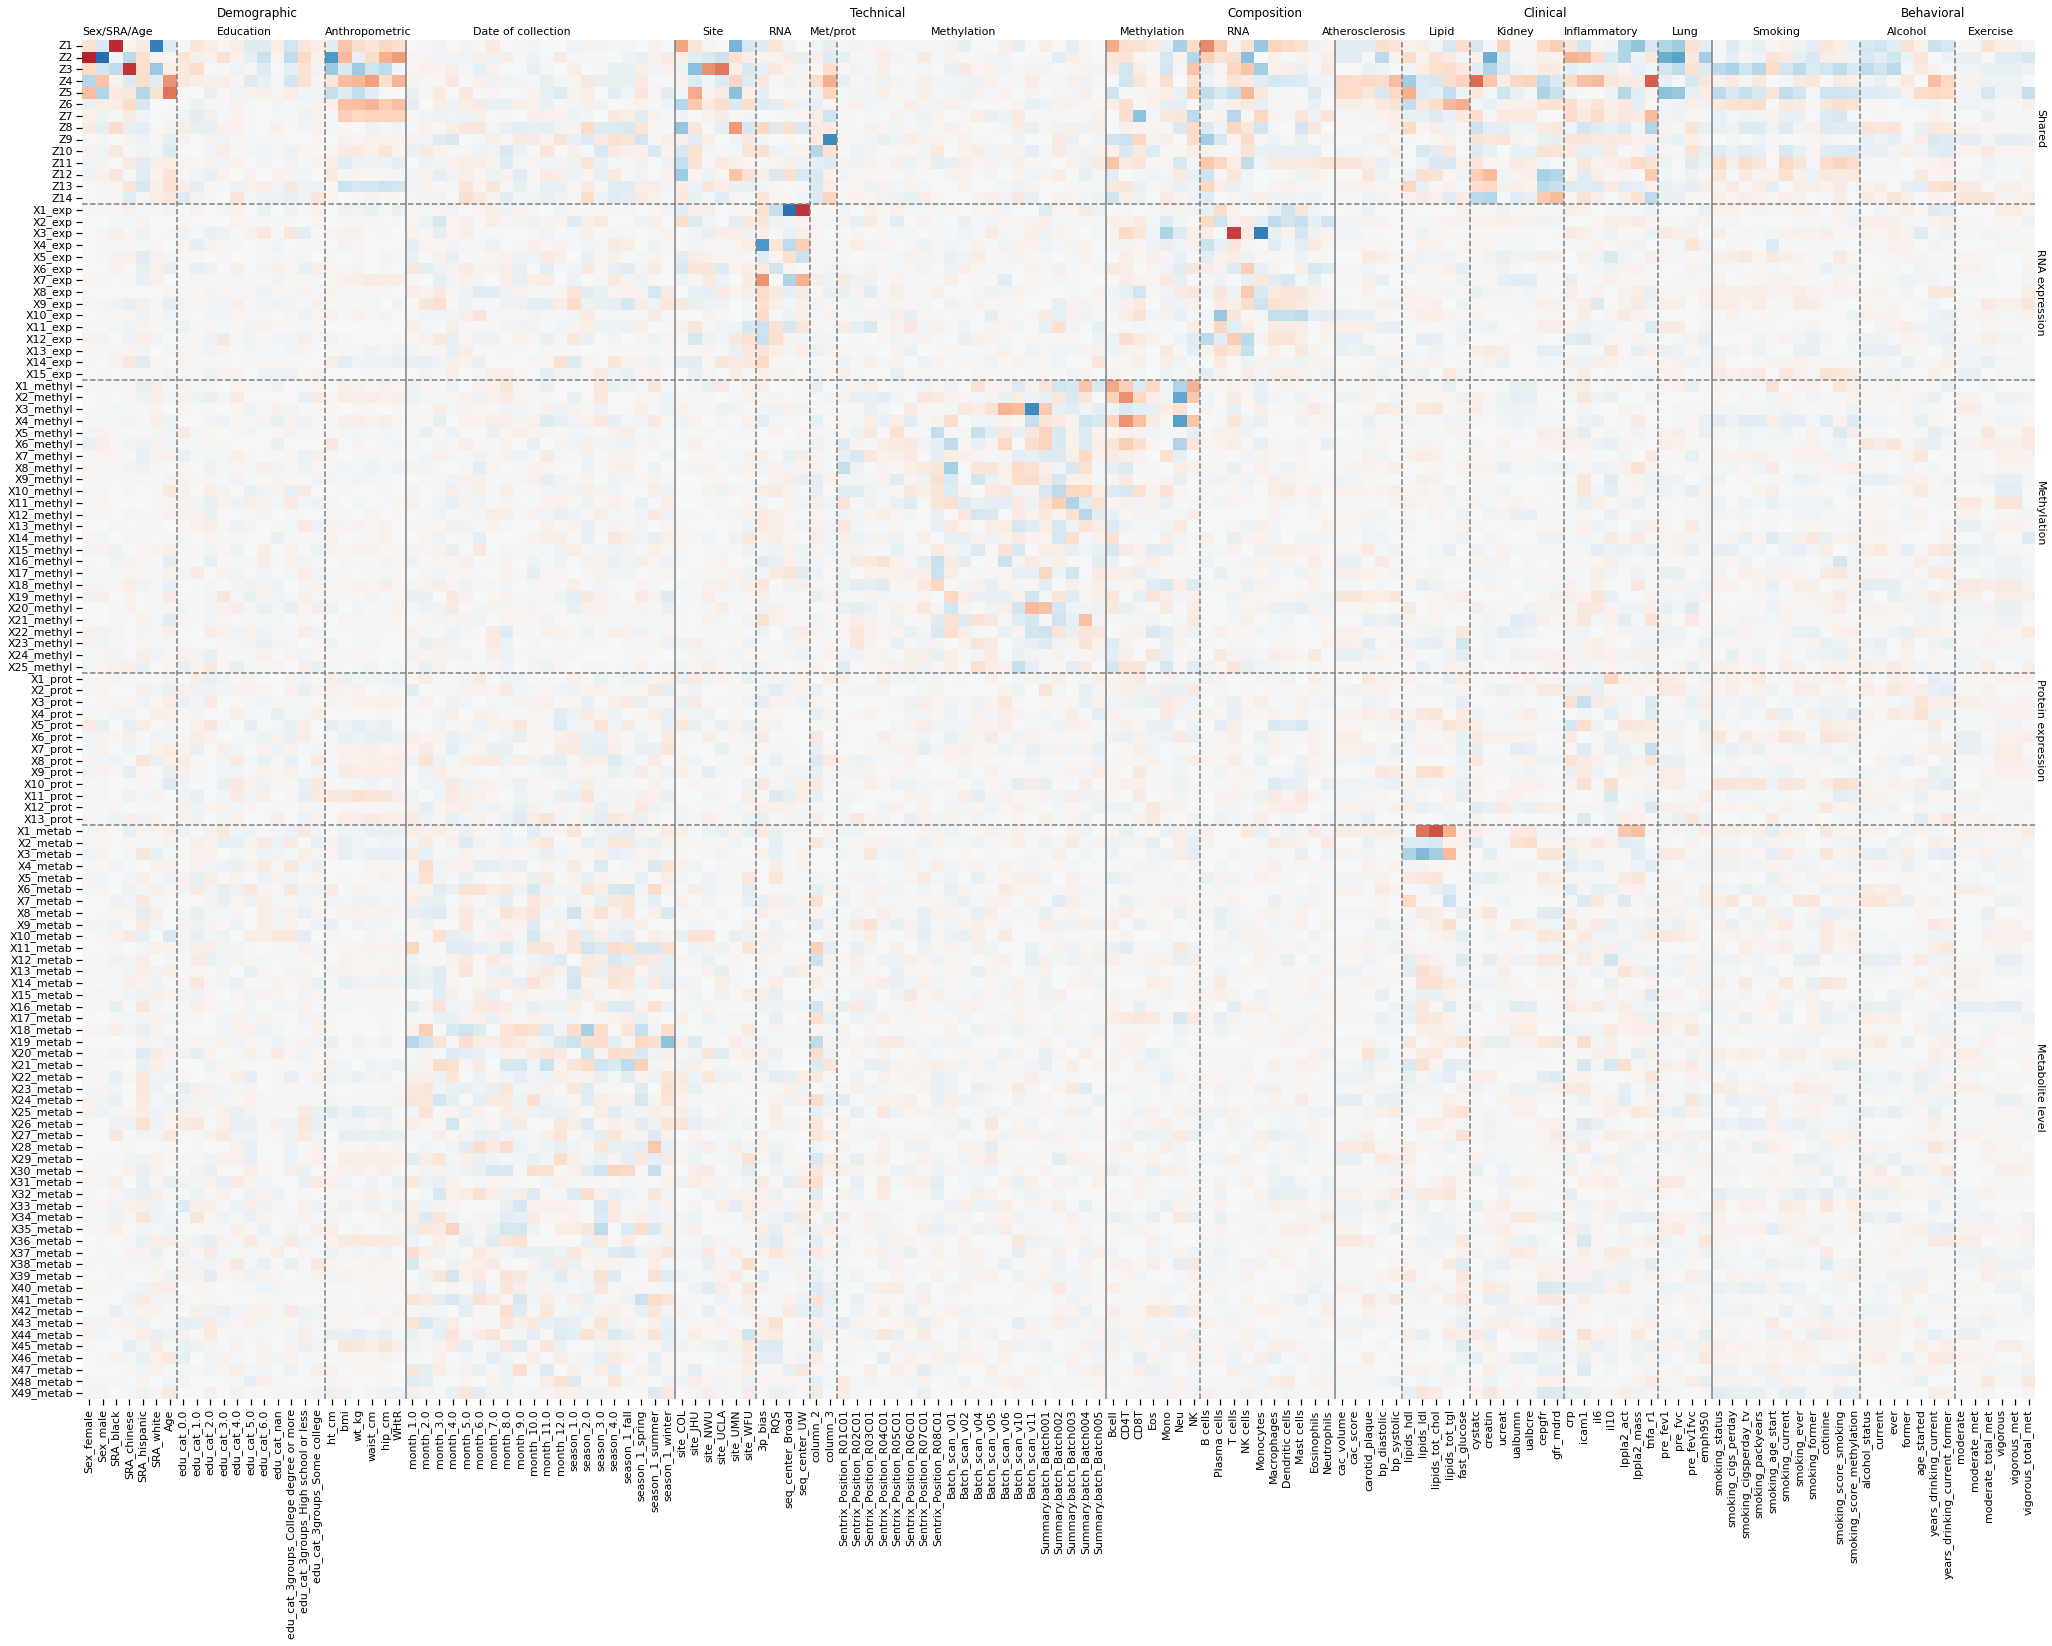

In [ ]:
sns.set_context("notebook")
plt.figure(figsize=(35, 25))

order = pd.read_csv('/gpfs/commons/projects/MESA/projects/mpcca/MESA_phenotype_order_with_dummies.csv', index_col='Phenotype')
data_cols = mcfa_res_df.shape[1]
covariate_cols = meta_df_dummies[order.index].shape[1]
# cor_data_1 = abs(mcfa_res_df.join(meta_df_dummies[order.index]).corr().iloc[0:data_cols, data_cols:])
# ax = sns.heatmap(cor_data_1, vmin=0, vmax=1, cbar=None)
cor_data_1 = mcfa_res_df.join(meta_df_dummies[order.index]).corr().iloc[0:data_cols, data_cols:]
ax = sns.heatmap(cor_data_1, vmin=-1, vmax=1, center=0, cmap='RdBu_r', cbar=None)
ax.vlines([24, 44, 76, 93, 121], *ax.get_ylim(), colors='gray')
ax.vlines([7, 18, 50, 54, 56, 83, 98, 103, 110, 117, 132, 139], *ax.get_ylim(), colors='gray', linestyles='dashed')
ax.hlines([14, 29, 54, 67], *ax.get_xlim(), colors='gray', linestyles='dashed')
ax.text(10, -2, 'Demographic', fontsize=12)
ax.text(57, -2, 'Technical', fontsize=12)
ax.text(85, -2, 'Composition', fontsize=12)
ax.text(107, -2, 'Clinical', fontsize=12)
ax.text(135, -2, 'Behavioral', fontsize=12)
ax.text(0, -0.5, 'Sex/SRA/Age', fontsize=11)
ax.text(10, -0.5, 'Education', fontsize=11)
ax.text(18, -0.5, 'Anthropometric', fontsize=11)
ax.text(29, -0.5, 'Date of collection', fontsize=11)
ax.text(46, -0.5, 'Site', fontsize=11)
ax.text(51, -0.5, 'RNA', fontsize=11)
ax.text(54, -0.5, 'Met/prot', fontsize=11)
ax.text(63, -0.5, 'Methylation', fontsize=11)
ax.text(77, -0.5, 'Methylation', fontsize=11)
ax.text(85, -0.5, 'RNA', fontsize=11)
ax.text(92, -0.5, 'Atherosclerosis', fontsize=11)
ax.text(100, -0.5, 'Lipid', fontsize=11)
ax.text(105, -0.5, 'Kidney', fontsize=11)
ax.text(110, -0.5, 'Inflammatory', fontsize=11)
ax.text(118, -0.5, 'Lung', fontsize=11)
ax.text(124, -0.5, 'Smoking', fontsize=11)
ax.text(134, -0.5, 'Alcohol', fontsize=11)
ax.text(140, -0.5, 'Exercise', fontsize=11)
ax.text(145, 9, 'Shared', rotation=270, fontsize=11)
ax.text(145, 25, 'RNA expression', rotation=270, fontsize=11)
ax.text(145, 43, 'Methylation', rotation=270, fontsize=11)
ax.text(145, 63, 'Protein expression', rotation=270, fontsize=11)
ax.text(145, 93, 'Metabolite level', rotation=270, fontsize=11)
plt.show()

In [ ]:
cor_data_1.to_csv('/gpfs/commons/projects/MESA/projects/mpcca/cor_data_1.csv')

In [ ]:
logistic_null = linear_model.LogisticRegression(penalty='none', max_iter=1000, fit_intercept=False)
logistic_fit = linear_model.LogisticRegression(penalty='none', max_iter=1000)
linear = linear_model.LinearRegression()

pred_res = {}
for col in meta_df.columns:
  mask = ~pd.isna(meta_df[col])
  scores = []
  for factor in [mcfa_res.Z] + list(mcfa_res.X.values()):
    if len(pd.unique(meta_df[col])) < 13:
      intercept = np.ones((sum(mask),1))
      null_model = logistic_null.fit(intercept, meta_df[col][mask])
      fit_model = logistic_fit.fit(factor[mask], meta_df[col][mask])
      null_ll = metrics.log_loss(meta_df[col][mask], null_model.predict_proba(intercept), normalize=False)
      fit_ll = metrics.log_loss(meta_df[col][mask], fit_model.predict_proba(factor[mask]), normalize=False)
      r2_score = 1.0 - fit_ll/null_ll
    else:
      fit_model = linear.fit(factor[mask], meta_df[col][mask])
      r2_score = fit_model.score(factor[mask], meta_df[col][mask])
    scores.append(r2_score)
  pred_res[col] = scores
pred_res_1 = pd.DataFrame(pred_res, index=['Z', 'X_exp', 'X_methyl', 'X_protein', 'X_metab'])

/gpfs/commons/home/bbrown/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/commons/home/bbrown/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

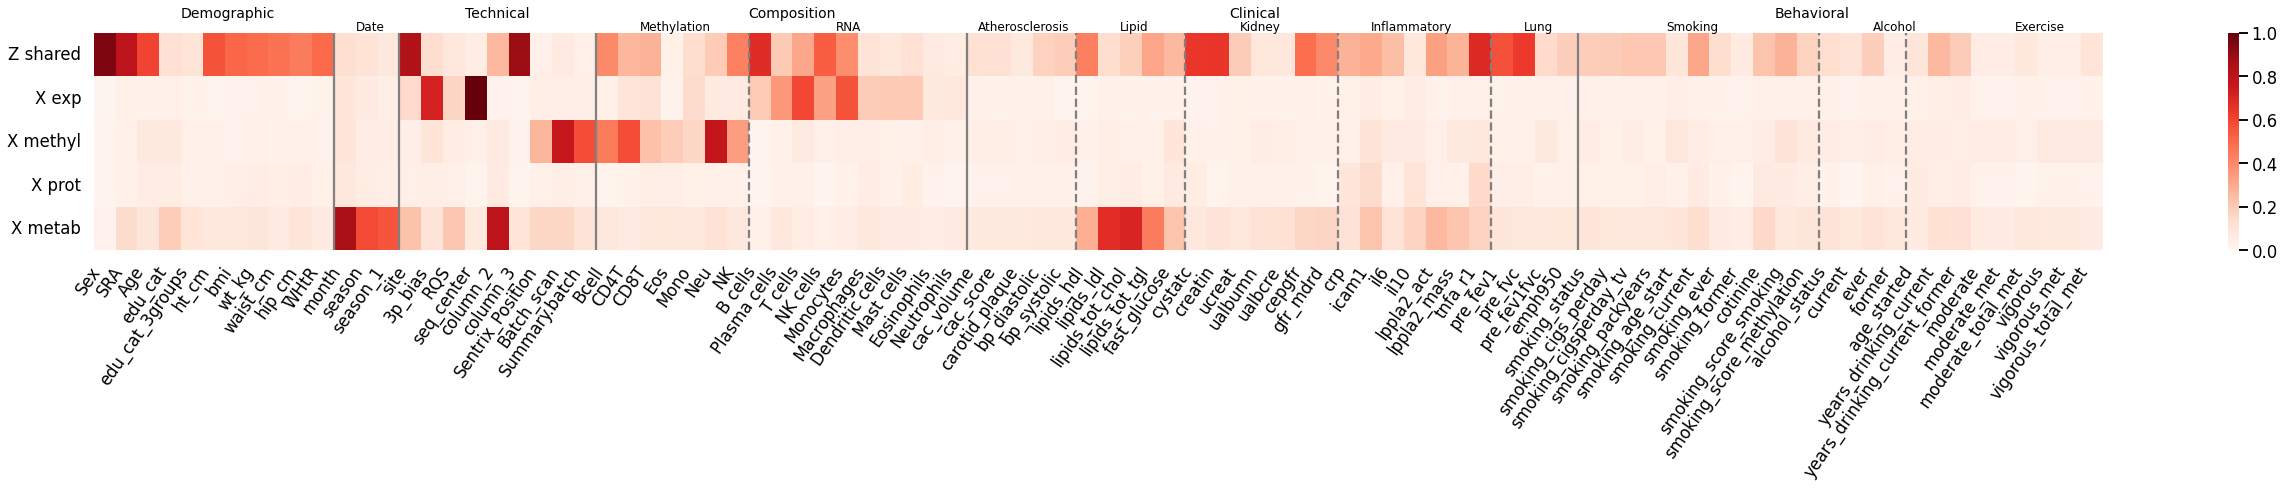

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(45, 4))

order = pd.read_csv('/gpfs/commons/projects/MESA/projects/mpcca/MESA_phenotype_order_normal.csv', index_col='Phenotype')
pred_res_1 = pred_res_1[order.index]
ax = sns.heatmap(pred_res_1, vmin=0, vmax=1, cmap='Reds')
ax.set_xticklabels(ax.get_xticklabels(), rotation=55, horizontalalignment='right')
ax.set_yticklabels(["Z shared", "X exp", "X methyl", "X prot", "X metab"], rotation=0)
ax.tick_params(bottom=False, left=False)

ax.vlines([11, 14, 23, 40, 68], *ax.get_ylim(), colors='gray')
# ax.vlines([3, 5, 14, 33, 48, 53, 60, 67, 82, 89], *ax.get_ylim(), colors='gray', linestyles='dashed')
ax.vlines([30, 45, 50, 57, 64, 79, 83], *ax.get_ylim(), colors='gray', linestyles='dashed')
ax.text(4, -0.35, 'Demographic', fontsize=14)
ax.text(17, -0.35, 'Technical', fontsize=14)
ax.text(30, -0.35, 'Composition', fontsize=14)
ax.text(52, -0.35, 'Clinical', fontsize=14)
ax.text(77, -0.35, 'Behavioral', fontsize=14)
# ax.text(0, -0.5, 'Sex/Race/Age', fontsize=11)
# ax.text(10, -0.5, 'Education', fontsize=11)
# ax.text(17, -0.5, 'Anthropometric', fontsize=11)
ax.text(12, -0.05, 'Date', fontsize=12)
# ax.text(49, -0.5, 'Site', fontsize=11)
# ax.text(54, -0.5, 'RNA', fontsize=11)
# ax.text(57, -0.5, 'Met/prot', fontsize=11)
# ax.text(66, -0.5, 'Methylation', fontsize=11)
ax.text(25, -0.05, 'Methylation', fontsize=12)
ax.text(34, -0.05, 'RNA', fontsize=12)
ax.text(40.5, -0.05, 'Atherosclerosis', fontsize=12)
ax.text(47, -0.05, 'Lipid', fontsize=12)
ax.text(52.5, -0.05, 'Kidney', fontsize=12)
ax.text(58.5, -0.05, 'Inflammatory', fontsize=12)
ax.text(65.5, -0.05, 'Lung', fontsize=12)
ax.text(72, -0.05, 'Smoking', fontsize=12)
ax.text(81.5, -0.05, 'Alcohol', fontsize=12)
ax.text(88, -0.05, 'Exercise', fontsize=12)
plt.show()

In [ ]:
pred_res_1.to_csv('/gpfs/commons/projects/MESA/projects/mpcca/pred_res_1.csv')

In [ ]:
logistic_null = linear_model.LogisticRegression(penalty='none', max_iter=1000, fit_intercept=False)
logistic_fit = linear_model.LogisticRegression(penalty='none', max_iter=1000, fit_intercept=False)
linear_null = linear_model.LinearRegression(fit_intercept=False)
linear_fit = linear_model.LinearRegression(fit_intercept=False)

pred_res = {}
null_vars = pd.get_dummies(meta_df['site'])
null_vars['intercept'] = np.ones((null_vars.shape[0],))
for col in meta_df.columns.drop('site'):
  mask = ~pd.isna(meta_df[col])
  scores = []
  for factor in [mcfa_res.Z] + list(mcfa_res.X.values()):
    if len(pd.unique(meta_df[col])) < 13:
      fit_vars = np.concatenate([factor[mask], null_vars[mask]], 1)
      null_model = logistic_null.fit(null_vars[mask], meta_df[col][mask])
      fit_model = logistic_fit.fit(fit_vars, meta_df[col][mask])
      null_ll = metrics.log_loss(meta_df[col][mask], null_model.predict_proba(null_vars[mask]), normalize=False)
      fit_ll = metrics.log_loss(meta_df[col][mask], fit_model.predict_proba(fit_vars), normalize=False)
      r2_score = 1.0 - fit_ll/null_ll
    else:
      r2_score = 0
      null_model = linear_null.fit(null_vars[mask], meta_df[col][mask])
      resid = (meta_df[col][mask] - null_model.predict(null_vars[mask])).values
      fit_model = linear_fit.fit(factor[mask], resid)
      r2_score = fit_model.score(factor[mask], resid)
    scores.append(r2_score)
  pred_res[col] = scores
pred_res_1_no_site = pd.DataFrame(pred_res, index=['Z', 'X_exp', 'X_methyl', 'X_protein', 'X_metab'])

/gpfs/commons/home/bbrown/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
pred_res_1_no_site

Sex       Age   3p_bias       RQS  seq_center  column_2  \
Z          0.955038  0.592473  0.062420  0.015604    0.066985  0.257709   
X_exp      0.004698  0.022438  0.764297  0.128125    0.999999  0.020094   
X_methyl   0.015162  0.073483  0.100515  0.061043    0.037478  0.069175   
X_protein  0.011796  0.050866  0.047602  0.038641    0.015344  0.077448   
X_metab    0.020502  0.096531  0.112561  0.229450    0.071963  0.838098   

           column_3  Sentrix_Position  Batch_scan  Summary.batch  ...  \
Z          0.906826          0.040455    0.062303       0.035356  ...   
X_exp      0.019395          0.046616    0.040223       0.040098  ...   
X_methyl   0.018392          0.270848    0.786444       0.592515  ...   
X_protein  0.017273          0.025835    0.044019       0.035264  ...   
X_metab    0.098471          0.159026    0.169487       0.132984  ...   

                bmi  waist_cm    hip_cm  moderate  moderate_met  \
Z          0.481821  0.441356  0.366836  0.042572      0.042544   
X_exp      0.013110  0.021729  0.014202  0.014026      0.014017   
X_methyl   0.020324  0.020555  0.033838  0.048174      0.048176   
X_protein  0.038130  0.044112  0.044911  0.017677      0.017683   
X_metab    0.080889  0.069875  0.099954  0.057696      0.057667   

           moderate_total_met  vigorous  vigorous_met  vigorous_total_met  \
Z                    0.070462  0.035283      0.035285            0.095047   
X_exp                0.020002  0.014609      0.014616            0.021440   
X_methyl             0.039872  0.067178      0.067187            0.062996   
X_protein            0.011455  0.023024      0.023031            0.016533   
X_metab              0.083078  0.071235      0.071242            0.057215   

                SRA  
Z          0.715575  
X_exp      0.082964  
X_methyl   0.056213  
X_protein  0.039561  
X_metab    0.220353  

[5 rows x 90 columns]

In [ ]:
pred_res_1_no_site.to_csv('/gpfs/commons/projects/MESA/projects/mpcca/pred_res_1_no_site.csv')

In [ ]:
Z = preprocessing.StandardScaler().fit_transform(mcfa_res.Z)
X_exp = preprocessing.StandardScaler().fit_transform(mcfa_res.X['exp'])
X_methyl = preprocessing.StandardScaler().fit_transform(mcfa_res.X['methyl'])
X_protein = preprocessing.StandardScaler().fit_transform(mcfa_res.X['prot'])
X_metab = preprocessing.StandardScaler().fit_transform(mcfa_res.X['metab'])

In [ ]:
embedding_Z = umap.UMAP().fit_transform(Z)
embedding_exp = umap.UMAP().fit_transform(X_exp)
embedding_methyl = umap.UMAP().fit_transform(X_methyl)
embedding_protein = umap.UMAP().fit_transform(X_protein)
embedding_metab = umap.UMAP().fit_transform(X_metab)

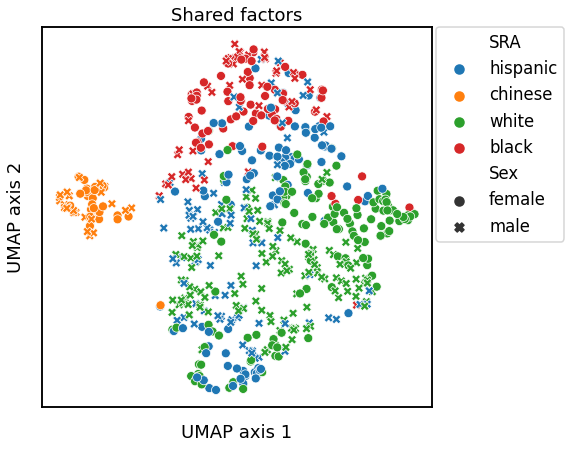

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(7, 7))
ax = sns.scatterplot(data=pd.DataFrame(embedding_Z, columns=['Ax1', 'Ax2'], index=mcfa_res_df.index), x='Ax1', y='Ax2', hue=meta_df['SRA'], style=meta_df['Sex'])
ax.set(xlabel='UMAP axis 1', ylabel='UMAP axis 2', title='Shared factors')
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0.)
plt.show()

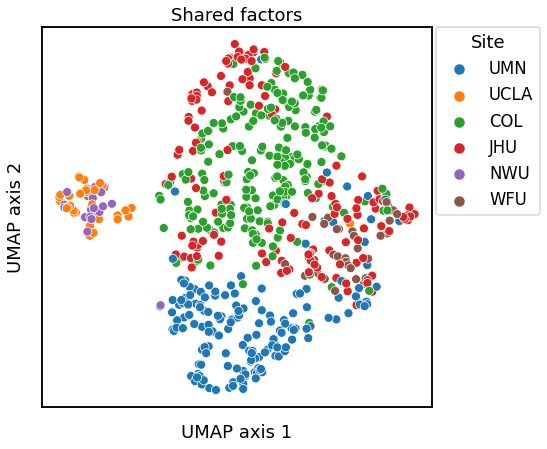

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(7, 7))
ax = sns.scatterplot(data=pd.DataFrame(embedding_Z, columns=['Ax1', 'Ax2'], index=mcfa_res_df.index), x='Ax1', y='Ax2', hue=meta_df['site'])
ax.set(xlabel='UMAP axis 1', ylabel='UMAP axis 2', title='Shared factors')
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0., title="Site")

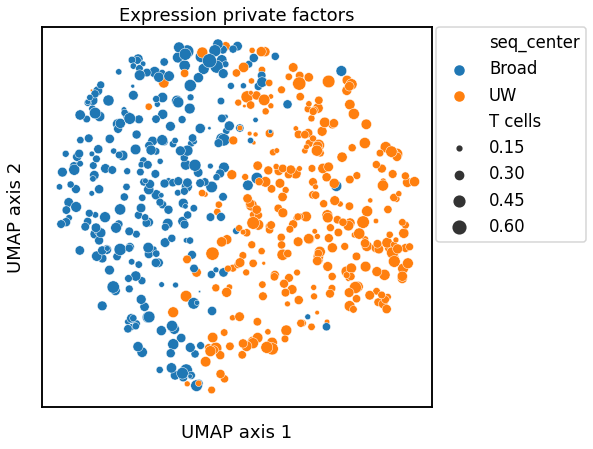

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(7, 7))
ax = sns.scatterplot(data=pd.DataFrame(embedding_exp, columns=['Ax1', 'Ax2'], index=mcfa_res_df.index), x='Ax1', y='Ax2', hue=meta_df['seq_center'], size=meta_df['T cells'], sizes=(2, 200))
ax.set(xlabel='UMAP axis 1', ylabel='UMAP axis 2', title='Expression private factors')
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0.)
plt.show()

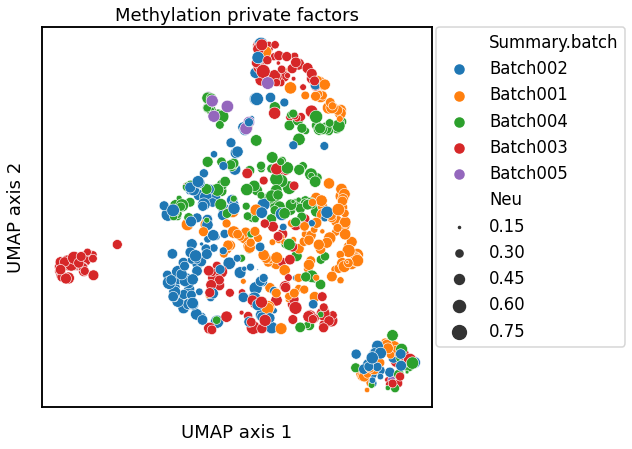

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(7, 7))
ax = sns.scatterplot(data=pd.DataFrame(embedding_methyl, columns=['Ax1', 'Ax2'], index=mcfa_res_df.index), x='Ax1', y='Ax2', hue=meta_df['Summary.batch'], size=meta_df['Neu'], sizes=(2,200))
ax.set(xlabel='UMAP axis 1', ylabel='UMAP axis 2', title='Methylation private factors')
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0.)
plt.show()

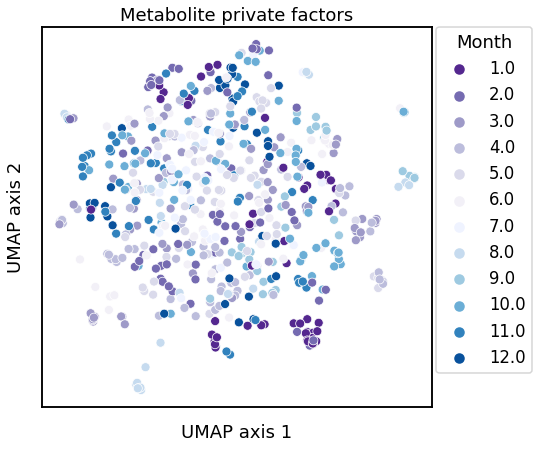

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(7, 7))
months = list(map(str, map(float, range(1,13))))
colors = ["#54278f", "#756bb1", "#9e9ac8", "#bcbddc", "#dadaeb", "#f2f0f7", "#eff3ff", "#c6dbef", "#9ecae1", "#6baed6", "#3182bd", "#08519c"]
palette = dict(zip(months, colors))
ax = sns.scatterplot(data=pd.DataFrame(embedding_metab, columns=['Ax1', 'Ax2'], index=mcfa_res_df.index), x='Ax1', y='Ax2', hue=meta_df['month'], palette = palette, hue_order=months)
ax.set(xlabel='UMAP axis 1', ylabel='UMAP axis 2', title='Metabolite private factors')
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0., title='Month')
plt.show()

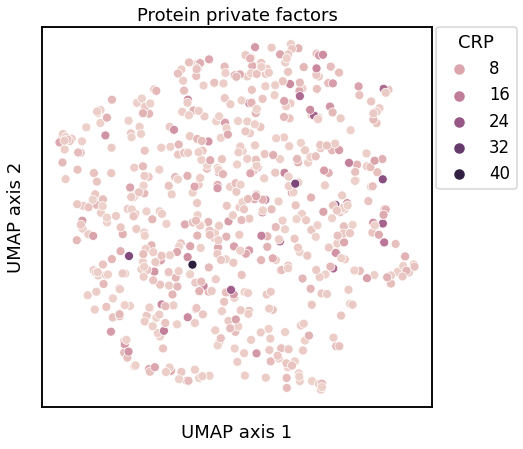

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(7, 7))
ax = sns.scatterplot(data=pd.DataFrame(embedding_protein, columns=['Ax1', 'Ax2'], index=mcfa_res_df.index), x='Ax1', y='Ax2', hue=meta_df['crp'])
ax.set(xlabel='UMAP axis 1', ylabel='UMAP axis 2', title='Protein private factors')
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0., title='CRP')
plt.show()

In [ ]:
%%time
# Cross-validation
Z_cv, X_cv, nrmse_tr, nrmse_te = mcfa.mcfa_cv(Y, mcfa_res, folds='loo', threads=0)

In [ ]:
# TODO(brielin): do this in the function
Z_cv_df = pd.DataFrame(Z_cv, index=mcfa_res.Z.index, columns=mcfa_res.Z.columns)
X_cv_df = [pd.DataFrame(X_m_cv, index=mcfa_X_m.index, columns=mcfa_X_m.columns) for X_m_cv, mcfa_X_m in zip(X_cv, mcfa_res.X.values())]
nrmse_tr_df = pd.DataFrame(nrmse_tr, index=mcfa_res.Z.index, columns=Y.keys())
nrmse_te_df = pd.DataFrame(nrmse_te, index=mcfa_res.Z.index, columns=Y.keys())

In [ ]:
cv_res_df = pd.concat([Z_cv_df] + X_cv_df, axis=1)
cv_res_df.to_csv(factor_cv_fn)
nrmse_tr_df.to_csv(nrmse_tr_fn)
nrmse_te_df.to_csv(nrmse_te_fn)

In [ ]:
cv_res_df = pd.read_csv(factor_cv_fn, index_col=0)
nrmse_tr_df = pd.read_csv(nrmse_tr_fn, index_col=0)
nrmse_te_df = pd.read_csv(nrmse_te_fn, index_col=0)

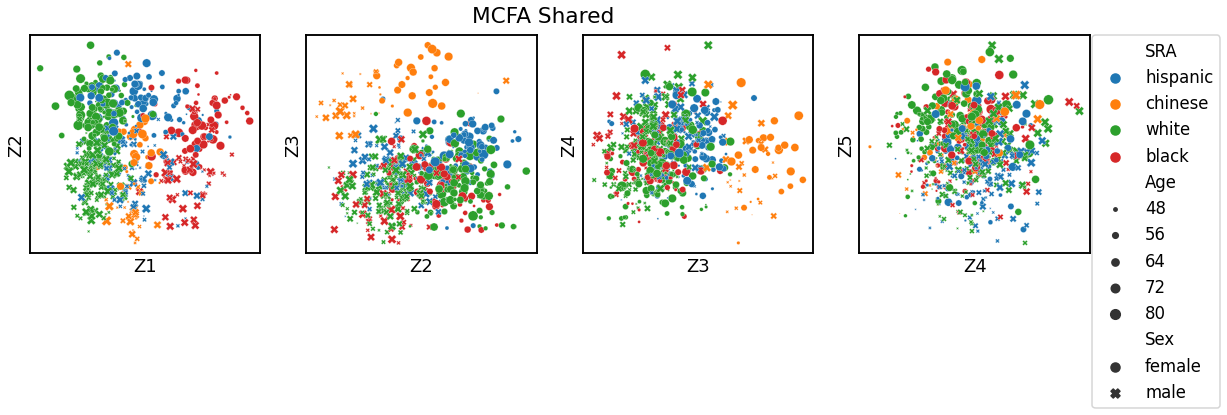

In [ ]:
sns.set_context('talk')
figure, axes = plt.subplots(1, 4, sharex=False, figsize=(19,4))
figure.suptitle('MCFA Shared')

for ax, x, y in zip(axes, ['Z1', 'Z2', 'Z3', 'Z4'], ['Z2', 'Z3', 'Z4', 'Z5']):
    # ax.set_title(x + ' vs ' + y)
    ax.set(xticklabels=[], yticklabels=[])
    ax.yaxis.labelpad = -8
    ax.xaxis.labelpad = -8
    ax.tick_params(bottom=False, left=False)
    sns.scatterplot(ax=ax, data=cv_res_df, x=x, y=y, sizes=(1,100),
                    hue=meta_df['SRA'], style=meta_df['Sex'], size=meta_df['Age'],
                    legend=True if y=='Z5' else False)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0.)
figure.show()

In [ ]:
Z_cv = preprocessing.StandardScaler().fit_transform(cv_res_df.iloc[:, 0:14].values)
embedding_Z = umap.UMAP().fit_transform(Z_cv)

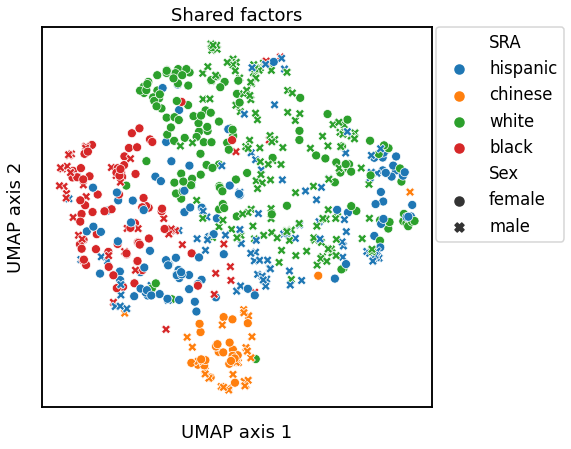

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(7, 7))
ax = sns.scatterplot(data=pd.DataFrame(embedding_Z, columns=['Ax1', 'Ax2'], index=mcfa_res_df.index), x='Ax1', y='Ax2', hue=meta_df['SRA'], style=meta_df['Sex'])
ax.set(xlabel='UMAP axis 1', ylabel='UMAP axis 2', title='Shared factors')
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0.)
plt.show()

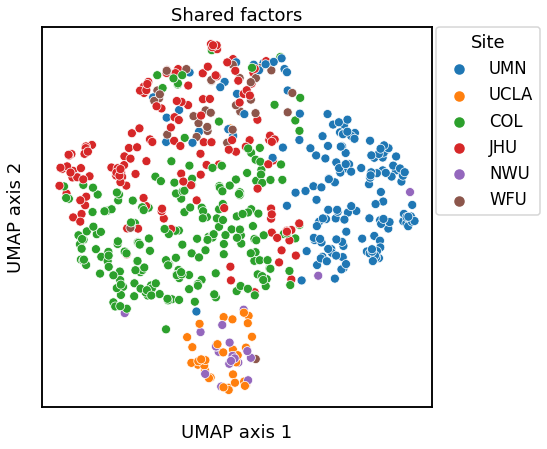

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(7, 7))
ax = sns.scatterplot(data=pd.DataFrame(embedding_Z, columns=['Ax1', 'Ax2'], index=mcfa_res_df.index), x='Ax1', y='Ax2', hue=meta_df['site'])
ax.set(xlabel='UMAP axis 1', ylabel='UMAP axis 2', title='Shared factors')
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0., title="Site")

In [ ]:
nrmse_tr_df['split'] = 'Train'
nrmse_te_df['split'] = 'Test'
nrmse = pd.concat([nrmse_tr_df, nrmse_te_df]).reset_index().melt(
    id_vars=['index', 'split'], value_vars=['exp', 'methyl', 'prot', 'metab'], value_name='NRMSE', var_name='Dataset')

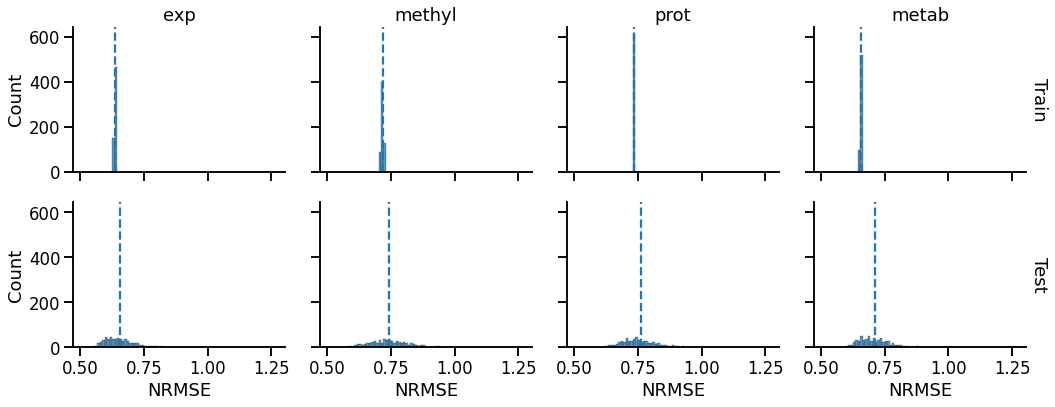

In [ ]:
sns.set_context('talk')
g = sns.displot(data=nrmse, x='NRMSE', row='split', col='Dataset', height=3, aspect=1.25, facet_kws = {'margin_titles': True})
for (row_val, col_val), ax in g.axes_dict.items():
  ax.axvline(nrmse.loc[(nrmse.split==row_val)&(nrmse.Dataset==col_val), 'NRMSE'].mean(), ls='--')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.tight_layout()
plt.show()

In [ ]:
# TODO(brielin): factors have been re-ordered since F ran this.
new_order = [ 0,  1,  2,  3,  4,  6,  7,  5, 10,  8,  9, 11, 12, 13]
teqtl_enrichment_fn = "/gpfs/commons/projects/MESA/projects/mpcca/factor_gwas_sumstats/teqtl_enrichment/"

In [ ]:
gwas_enrich = pd.read_table(teqtl_enrichment_fn + 'enrichment_table_gwas_snps.txt', names = ('mean', 'sd', 'stat'), sep=' ')
teqtl_enrich = pd.read_table(teqtl_enrichment_fn + 'enrichment_table_trans_eqtls.txt', names = ('mean', 'sd', 'stat'), sep=' ')
iteqtl_enrich = pd.read_table(teqtl_enrichment_fn + 'enrichment_table_infl_teqtls.txt', names = ('mean', 'sd', 'stat'), sep=' ')
gwas_enrich['type'] = 'gwas'
teqtl_enrich['type'] = 'teqtl'
iteqtl_enrich['type'] = 'iteqtl'

In [ ]:
gwas_enrich = gwas_enrich.loc[new_order].reset_index()
teqtl_enrich = teqtl_enrich.loc[new_order].reset_index()
iteqtl_enrich = iteqtl_enrich.loc[new_order].reset_index()

In [ ]:
enrich_results = pd.concat([gwas_enrich, teqtl_enrich, iteqtl_enrich])
enrich_results['p_value'] = 1 - stats.norm.cdf(enrich_results['stat'])
sig, p_adj = multitest.fdrcorrection(enrich_results.p_value)
enrich_results['p_adj'] = p_adj
enrich_results['sig'] = sig

In [ ]:
enrich_results.loc[enrich_results.type == 'gwas']

index      mean        sd      stat  type   p_value     p_adj    sig
0       0  1.065630  0.022175  2.959610  gwas  0.001540  0.010781   True
1       1  1.005160  0.022069  0.233727  gwas  0.407598  0.640295  False
2       2  1.027780  0.022759  1.220550  gwas  0.111128  0.245652  False
3       3  1.012710  0.022181  0.572830  gwas  0.283380  0.566760  False
4       4  0.938796  0.022084 -2.771470  gwas  0.997210  0.997210  False
5       6  1.052030  0.022046  2.360120  gwas  0.009135  0.042628   True
6       7  1.085140  0.022023  3.865830  gwas  0.000055  0.000775   True
7       5  0.991506  0.022193 -0.382747  gwas  0.649046  0.851873  False
8      10  0.987550  0.022574 -0.551536  gwas  0.709367  0.870401  False
9       8  1.056260  0.021981  2.559610  gwas  0.005239  0.027507   True
10      9  0.964555  0.022421 -1.580890  gwas  0.943048  0.966050  False
11     11  1.006560  0.022099  0.296856  gwas  0.383288  0.640295  False
12     12  1.049700  0.022429  2.216030  gwas  0.013345  0.056048  False
13     13  1.006450  0.022316  0.289218  gwas  0.386207  0.640295  False

In [ ]:
enrich_results.loc[enrich_results.type == 'teqtl']

index      mean        sd      stat   type   p_value     p_adj    sig
0       0  1.095230  0.035975  2.647200  teqtl  0.004058  0.024348   True
1       1  1.060180  0.035803  1.680760  teqtl  0.046405  0.114647  False
2       2  1.074700  0.036922  2.023070  teqtl  0.021533  0.075365  False
3       3  1.063420  0.035984  1.762550  teqtl  0.038988  0.109167  False
4       4  0.976278  0.035827 -0.662137  teqtl  0.746058  0.870401  False
5       6  1.060200  0.035766  1.683200  teqtl  0.046168  0.114647  False
6       7  1.119280  0.035728  3.338690  teqtl  0.000421  0.003535   True
7       5  0.989898  0.036005 -0.280571  teqtl  0.610480  0.827102  False
8      10  1.002140  0.036622  0.058303  teqtl  0.476753  0.689060  False
9       8  1.051990  0.035661  1.457800  teqtl  0.072448  0.169045  False
10      9  0.952661  0.036374 -1.301450  teqtl  0.903448  0.948620  False
11     11  0.957360  0.035851 -1.189360  teqtl  0.882851  0.948620  False
12     12  1.013850  0.036388  0.380532  teqtl  0.351775  0.640295  False
13     13  1.032890  0.036204  0.908506  teqtl  0.181805  0.381791  False

In [ ]:
enrich_results.loc[enrich_results.type == 'iteqtl']

index      mean        sd      stat    type       p_value     p_adj    sig
0       0  1.160600  0.079343  2.024170  iteqtl  2.147633e-02  0.075365  False
1       1  1.290140  0.078965  3.674280  iteqtl  1.192605e-04  0.001252   True
2       2  1.150550  0.081432  1.848830  iteqtl  3.224118e-02  0.096724  False
3       3  1.368780  0.079363  4.646700  iteqtl  1.686436e-06  0.000035   True
4       4  1.028110  0.079016  0.355771  iteqtl  3.610060e-01  0.640295  False
5       6  1.001550  0.078883  0.019589  iteqtl  4.921857e-01  0.689060  False
6       7  1.388250  0.078798  4.927100  iteqtl  4.172952e-07  0.000018   True
7       5  0.932863  0.079409 -0.845462  iteqtl  8.010735e-01  0.909327  False
8      10  1.018040  0.080771  0.223385  iteqtl  4.116179e-01  0.640295  False
9       8  1.003890  0.078650  0.049415  iteqtl  4.802942e-01  0.689060  False
10      9  1.149670  0.080224  1.865680  iteqtl  3.104307e-02  0.096724  False
11     11  0.951460  0.079071 -0.613882  iteqtl  7.303533e-01  0.870401  False
12     12  0.962602  0.080254 -0.466004  iteqtl  6.793937e-01  0.864683  False
13     13  0.897242  0.079848 -1.286920  iteqtl  9.009389e-01  0.948620  False

In [ ]:
def qqplot_stats(data):
  # Data is pd.Series with Z-score
  sorted_z = (data**2).sort_values()
  index = sorted_z.index
  sorted_p = 1 - stats.chi2.cdf(np.asarray(sorted_z), df=1)
  n_points = len(sorted_p)
  quantiles = (np.arange(n_points) + 0.5) / (n_points)
  expected_z = stats.chi2.ppf(quantiles, df=1) 
  expected_p = -np.log10(1 - quantiles)
  observed = -np.log10(sorted_p)
  pdf = stats.chi2.pdf(expected_z, df=1)
  se_z = (1 / pdf) * np.sqrt(quantiles * (1 - quantiles) / n_points)
  lower_z = expected_z - 1.96*se_z
  upper_z = expected_z + 1.96*se_z
  lower_p = -np.log10(1 - stats.chi2.cdf(lower_z, df=1))
  upper_p = -np.log10(1 - stats.chi2.cdf(upper_z, df=1))
  return pd.DataFrame({'Expected': expected_p, 'Observed': observed, 'lower': lower_p, 'upper': upper_p, 'chi2_stat': sorted_z}, index=index)

def qqplot_wrap(data):
  # Data has Z-score and Type columns
  gw_stats = qqplot_stats(data['Z'])
  gw_stats = pd.concat([gw_stats.loc[gw_stats['Expected'] < 4].sample(100000).sort_values('Expected'), gw_stats.loc[gw_stats['Expected'] >= 4]])
  gw_stats['Type'] = 'Genome-wide'
  data_gwas = data.loc[data.Type != 'Other']
  gwas_stats = qqplot_stats(data_gwas['Z'])
  gwas_stats['Type'] = 'GWAS hits'
  data_teqtl = data.loc[(data.Type == 't-eQTL') | (data.Type == 'Influential t-eQTL')]
  teqtl_stats = qqplot_stats(data_teqtl['Z'])
  teqtl_stats['Type'] = 'trans-eQTLs'
  data_iteqtl = data.loc[data.Type == 'Influential t-eQTL']
  iteqtl_stats = qqplot_stats(data_iteqtl['Z'])
  iteqtl_stats['Type'] = 'Influential teQTLs'
  all_stats = pd.concat([gw_stats, gwas_stats, teqtl_stats, iteqtl_stats])
  return(all_stats)

def plot_qqplot(fname, factor, i=0, fontsize=11, **kwargs):
  sumstats = pd.read_table(fname.iloc[i], index_col='SNP')
  sumstats = pd.DataFrame(sumstats['Z']).join(gwas_qtl_list)
  sumstats['chi2_stat'] = sumstats['Z']**2
  sumstats['Type'] = np.where(sumstats.Count.isna(), 'Other', 'GWAS SNP')
  sumstats['Type'] = np.where(sumstats.Count > 0, 't-eQTL', sumstats.Type)
  sumstats['Type'] = np.where(sumstats.Count > 9, 'Influential t-eQTL', sumstats.Type)

  # all_mean = np.asarray(teqtl_stats.loc[(teqtl_stats['factor'] == factor.iloc[i]) & (teqtl_stats['t_gene_count'] == -1), ['mean_chi2', 'se_chi2', 'p_val']])
  gwas_mean = np.asarray(gwas_enrich.loc[factor.iloc[i], ['mean', 'sd']])
  teqtl_mean = np.asarray(teqtl_enrich.loc[factor.iloc[i], ['mean', 'sd']])
  iteqtl_mean = np.asarray(iteqtl_enrich.loc[factor.iloc[i], ['mean', 'sd']])
  print(gwas_mean)
  data = qqplot_wrap(sumstats)
  ax = sns.scatterplot(data=data, x='Expected', y='Observed', hue='Type', s=25, linewidth=0)
  ax.axline((0,0), slope=1)
  ax.text(1.4, 1.1, '\u03A7\u00b2 gwas hits: {:.4f}\u00B1{:.4f}'.format(*gwas_mean), fontsize=fontsize)
  ax.text(1.4, 0.6, '\u03A7\u00b2 trans-eqtls: {:.4f}\u00B1{:.4f}'.format(*teqtl_mean), fontsize=fontsize)
  ax.text(1.4, 0.1, '\u03A7\u00b2 infl. t-eqtls: {:.4f}\u00B1{:.4f}'.format(*iteqtl_mean), fontsize=fontsize)
  return(ax, data)

In [ ]:
gwas_folder = '/gpfs/commons/projects/MESA/projects/mpcca/factor_gwas_sumstats/'
gwas_qtl_list = pd.read_table(gwas_folder + 'teqtl_enrichment/eqtlgen_all_with_sig_counts.txt', sep=' ', index_col='SNP')
teqtl_info = pd.read_table(gwas_folder + 'teqtl_enrichment/eqtlgen_snp_info.csv', skiprows=2)
teqtl_info['SNP'] = teqtl_info['rs ID']
teqtl_info = teqtl_info.join(gwas_qtl_list, on='SNP')

In [ ]:
plots_to_make = pd.DataFrame({'factor': list(range(0, 14)), 'fname': [gwas_folder + 'sumstats/factors_exam1.gwas_pairs_maf05.Z_' + str(i) + '.sumstats' for i in new_order], 'Dimension': range(1,15)})

[1.06563 0.0221749]


[Text(0.5, 1.0, 'Factor 1')]

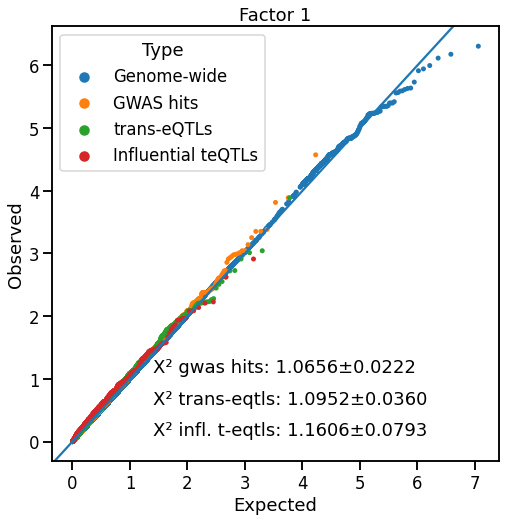

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(8, 8))
ax, _ = plot_qqplot(plots_to_make.fname, plots_to_make.factor, i=0, fontsize=18)
ax.set(title='Factor 1')

[1.00516 0.0220691]


[Text(0.5, 1.0, 'Factor 2')]

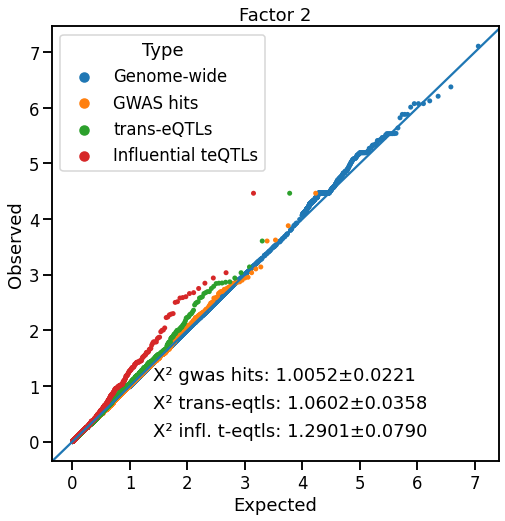

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(8, 8))
ax, _ = plot_qqplot(plots_to_make.fname, plots_to_make.factor, i=1, fontsize=18)
ax.set(title='Factor 2')

[1.05203 0.0220463]


[Text(0.5, 1.0, 'Factor 6')]

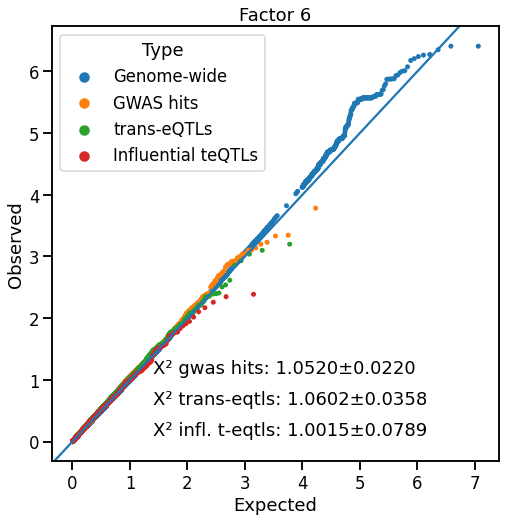

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(8, 8))
ax, data = plot_qqplot(plots_to_make.fname, plots_to_make.factor, i=5, fontsize=18)
ax.set(title='Factor 6')

[1.08514 0.0220226]


[Text(0.5, 1.0, 'Factor 7')]

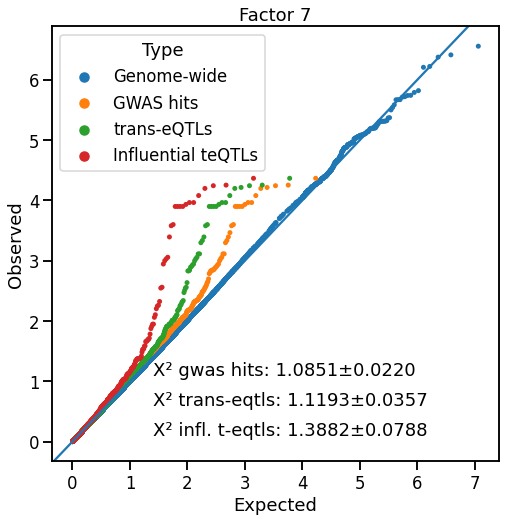

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(8, 8))
ax, data = plot_qqplot(plots_to_make.fname, plots_to_make.factor, i=6, fontsize=18)
ax.set(title='Factor 7')

[1.06563 0.0221749]
[1.00516 0.0220691]
[1.02778 0.0227587]
[1.01271 0.0221806]
[0.938796 0.0220836]
[1.05203 0.0220463]
[1.08514 0.0220226]
[0.991506 0.0221934]
[0.98755 0.022574]
[1.05626 0.0219813]
[0.964555 0.022421]
[1.00656 0.0220988]
[1.0497 0.0224294]
[1.00645 0.022316]


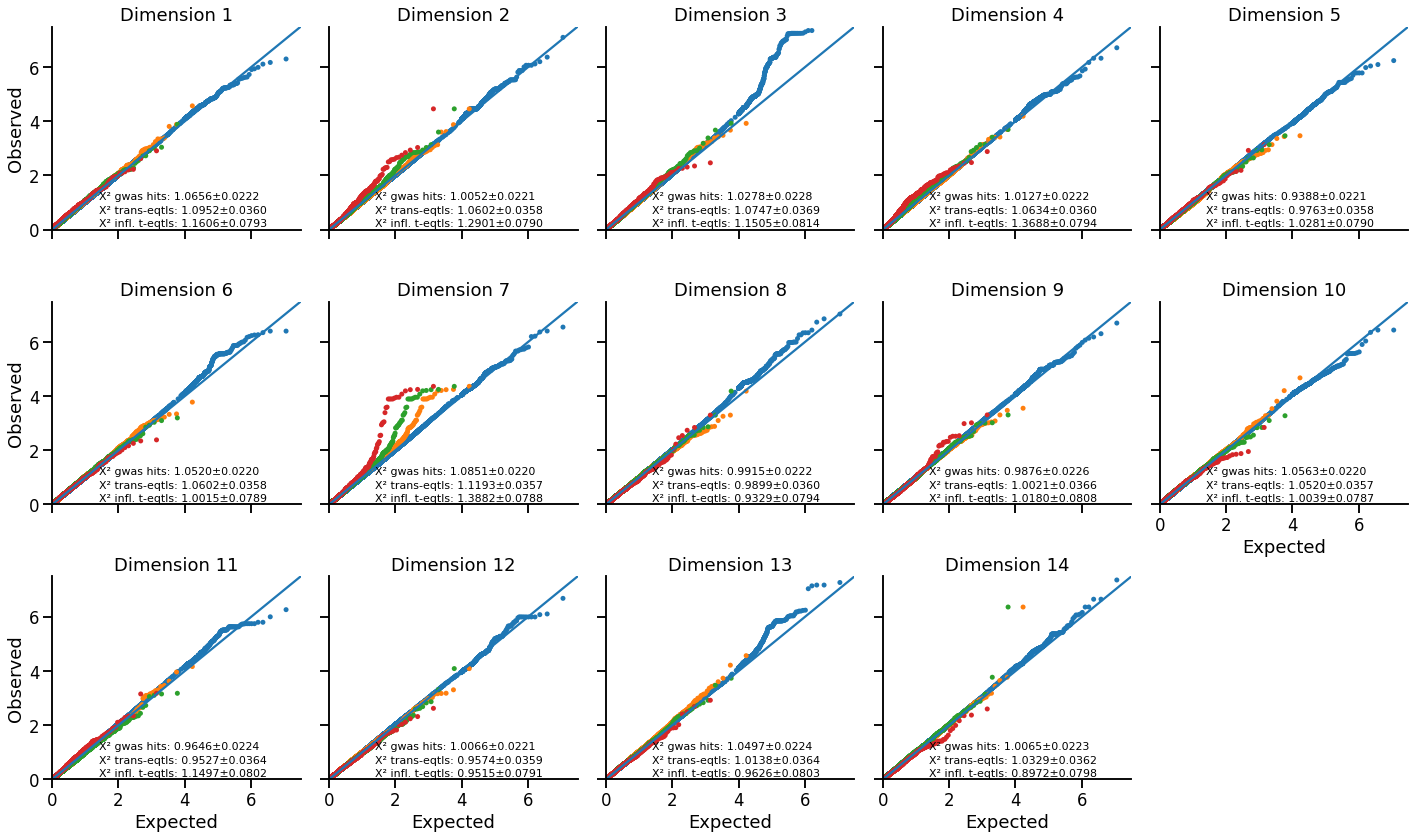

In [ ]:
g = sns.FacetGrid(plots_to_make, col='Dimension', col_wrap=5, height=4, aspect=1, xlim=(0, 7.5), ylim=(0, 7.5))
g.map(plot_qqplot, 'fname', 'factor')
g.set_titles('{col_var} {col_name}')
g.set_axis_labels("Expected", "Observed")

In [ ]:
meth_scores = mcfa._calc_gsea_scores(meth_data, Z, transform=True)
exp_scores = mcfa._calc_gsea_scores(exp_data, Z, transform=True)
prot_scores = mcfa._calc_gsea_scores(protein_data, Z, transform=True)
metab_scores = mcfa._calc_gsea_scores(metab_data, Z, transform=True)

In [ ]:
# 1 is correlated with ancestry as well as B cell proportion.
# We generally choose to to investigate factors 1/2 due to SRA correlations,
# though they may be interesting.
abs(cor_data_1.loc['Z1']).sort_values(ascending=False)[0:10]

SRA_black      0.742615
SRA_white      0.685057
B cells        0.476911
site_UMN       0.466419
site_COL       0.395619
lppla2_mass    0.395098
Monocytes      0.376954
Bcell          0.376635
pre_fvc        0.354046
Neu            0.325182
Name: Z1, dtype: float64

<AxesSubplot:xlabel='SRA', ylabel='B cells'>

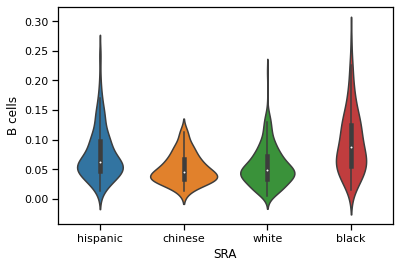

In [ ]:
sns.violinplot(data=meta_df, y='B cells', x='SRA')

In [ ]:
# 7

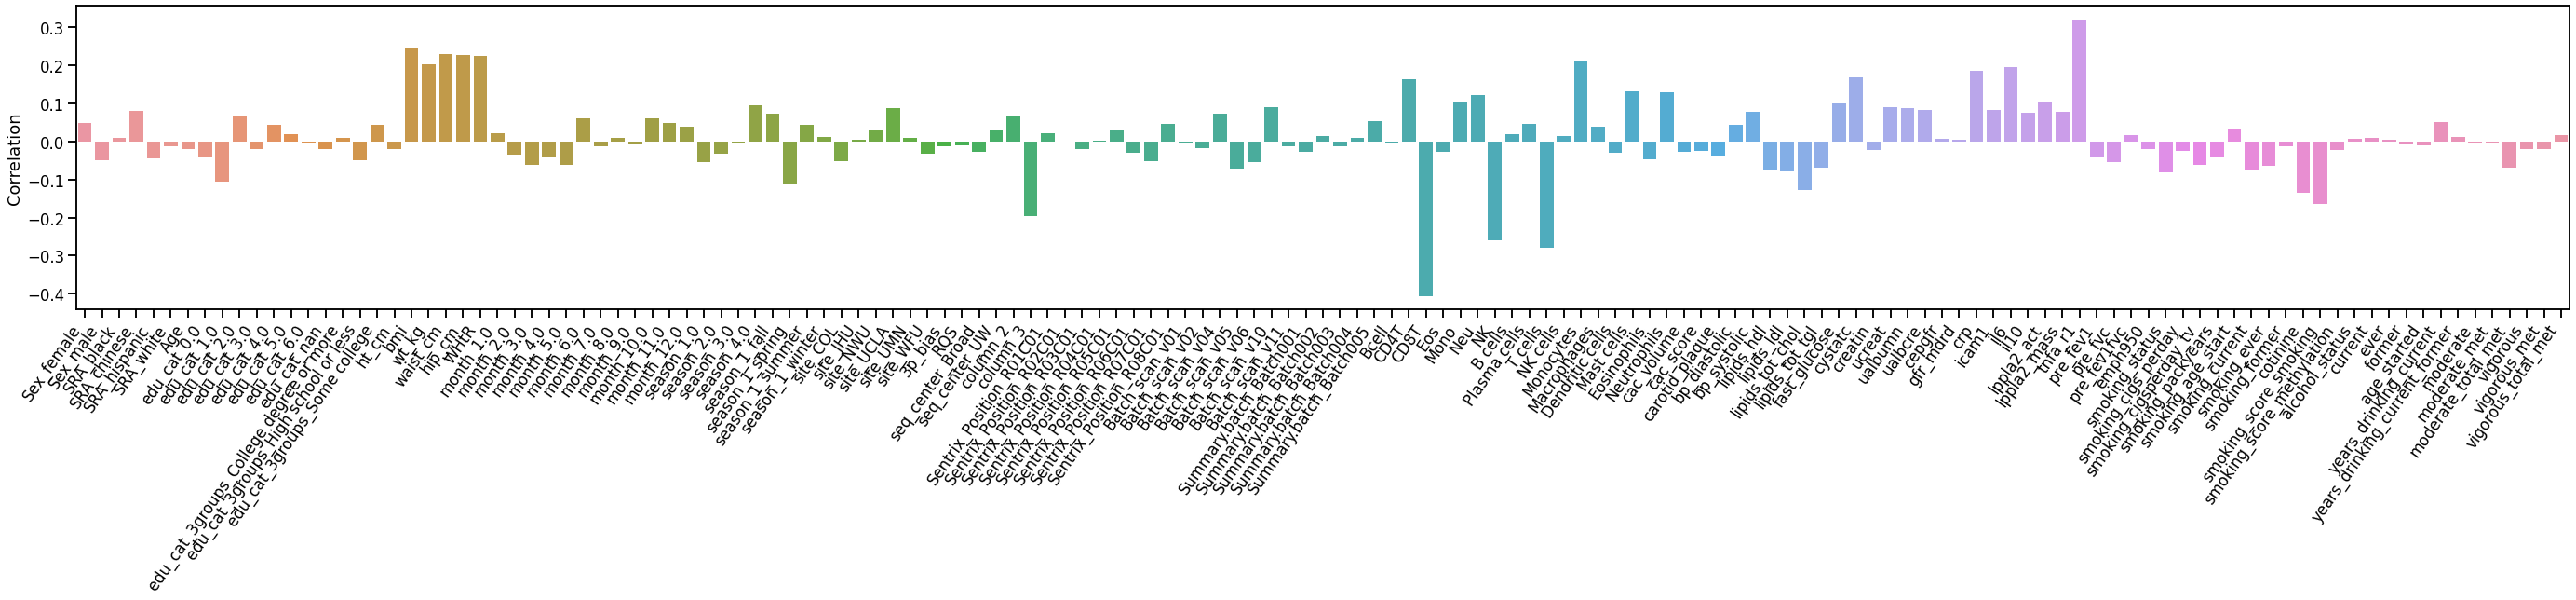

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(48, 6))
factor_cor_data = cor_data_1.loc['Z7']
ax = sns.barplot(x=factor_cor_data.index, y = factor_cor_data)
ax.set(ylabel='Correlation')
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=55, horizontalalignment='right')

(-0.42, 0.42)

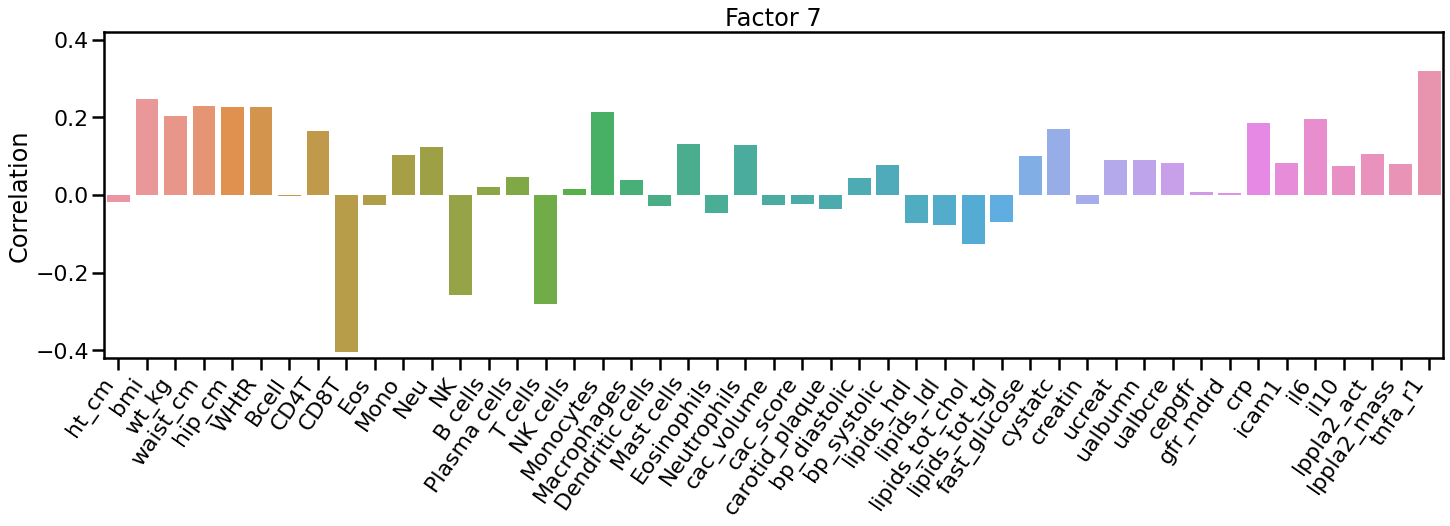

In [ ]:
sns.set_context('poster')
plt.figure(figsize=(24, 6))
factor_cor_data = cor_data_1.loc['Z7']
factor_cor_data = pd.concat([factor_cor_data[18:24], factor_cor_data[76:117]])
ax = sns.barplot(x=factor_cor_data.index, y = factor_cor_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=55, horizontalalignment='right')
ax.set(ylabel='Correlation', title='Factor 7')
ax.set_ylim(-0.42, 0.42)

In [ ]:
meth_scores['6abs'] = abs(meth_scores[6])
selected = meth_scores[[6, '6abs']].sort_values(by='6abs', ascending=False)[1:20]

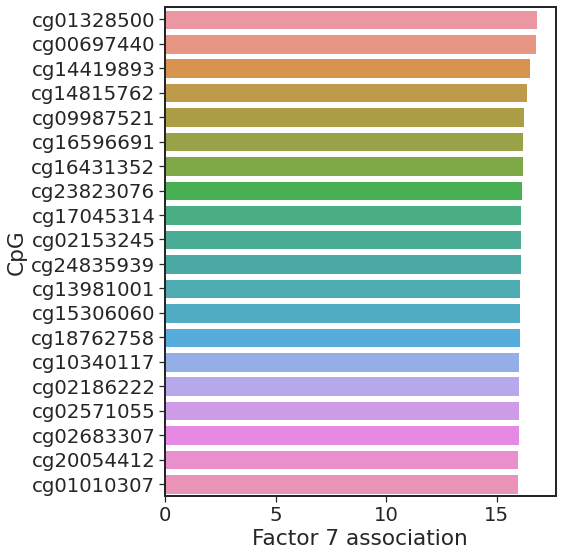

In [ ]:
sns.set(font_scale=1.8, style='ticks', rc={"axes.linewidth": 2})
plt.figure(figsize=(7, 9))
meth_scores['6abs'] = abs(meth_scores[6])
selected = meth_scores[[6, '6abs']].sort_values(by='6abs', ascending=False)[0:20]
ax = sns.barplot(data=selected.reset_index(), x=6, y='probe_id')
ax.set(xlabel='Factor 7 association', ylabel='CpG')
plt.show()

In [ ]:
dim_7_sumstats = pd.read_table(gwas_folder + 'sumstats/factors_exam1.gwas_pairs_maf05.Z_7.sumstats', index_col='SNP')
dim_7_sumstats['Chi2'] = dim_7_sumstats.Z**2
dim_7_sumstats['p_val'] = 1 - stats.chi2.cdf(dim_7_sumstats['Chi2'], df=1)
snp_factor_info_7 = teqtl_info.join(dim_7_sumstats, on='SNP').drop_duplicates(['rs ID', 'Trait'])
show_table_7 = snp_factor_info_7.loc[snp_factor_info_7['p_val'] < 0.01].sort_values(by='p_val')

In [ ]:
show_table_7['p_val'] = show_table_7['p_val'].apply(lambda x: round(x, 5))
show_table_7['Chr:Pos'] = show_table_7['Chr'].astype(str) + ":" + show_table_7['Position'].astype(str)

In [ ]:
show_table_7 = show_table_7.join(show_table_7.groupby('Trait')[['rs ID', 'p_val', 'Chr:Pos']].agg(list), on='Trait', rsuffix='(s)').sort_values(by='p_val').drop_duplicates('Trait')
show_table_7 = show_table_7.join(show_table_7.groupby('rs ID')[['Trait', 'PUBMED ID']].agg(list), on='rs ID', rsuffix='(s)').drop_duplicates('rs ID')
show_table_7['F7 p val(s)'] = show_table_7['p_val(s)']
show_table_7 = show_table_7[['Trait(s)', 'PUBMED ID(s)', 'rs ID(s)', 'Chr:Pos(s)', 'F7 p val(s)']]

In [ ]:
show_table_7[0:20]

Trait(s)  \
11507                       [Trans fatty acid levels, Red blood cell fatty acid levels, Metabolite levels]   
11572  [Glycerophospholipid levels, Plasma omega-6 polyunsaturated fatty acid levels (dihomo-gamma-lino...   
11575                                                                            [Blood metabolite levels]   
14111                                                                                             [Height]   
11554                                                      [Heart rate, Laryngeal squamous cell carcinoma]   
11592                                           [Phospholipid levels (plasma), Inflammatory bowel disease]   
11468  [Colorectal cancer, Plasma omega-6 polyunsaturated fatty acid levels (gamma-linolenic acid), Cro...   
11571                                                                                 [Cholesterol, total]   
11539  [Plasma omega-6 polyunsaturated fatty acid levels (linoleic acid), Resting heart rate, Metabolic...   
11566  [Plasma omega-6 polyunsaturated fatty acid levels (adrenic acid), Fasting glucose-related traits...   
11508                                                                        [Delta-6 desaturase activity]   
11517                                                                                    [LDL cholesterol]   
11549                                                         [Hematology traits, Blood metabolite ratios]   
2180                                                                        [Systemic lupus erythematosus]   
11616                                                                                        [QT interval]   
13518                                                                                [Mature red cell;HGB]   
18206                                                                                  [IgG glycosylation]   
11621                                                         [Liver enzyme levels (alkaline phosphatase)]   
7629                                                                                [Mean platelet volume]   
16853                                                                          [Polycystic ovary syndrome]   

                                                                           PUBMED ID(s)  \
11507                                                    [25646338, 25500335, 23378610]   
11572                                                              [26068415, 24823311]   
11575                                                                        [24816252]   
14111                                                                        [25429064]   
11554                                                              [23583979, 25194280]   
11592                                                              [21829377, 26192919]   
11468                                                    [24836286, 26584805, 26192919]   
11571                                                                        [25961943]   
11539  [26584805, 20639392, 21886157, 24823311, 26068415, 22286219, 19060906, 19060906]   
11566                                                    [24823311, 22581228, 20081858]   
11508                                                                        [26584805]   
11517                                                                        [24097068]   
11549                                                              [23303382, 24816252]   
2180                                                                         [23273568]   
11616                                                                        [24952745]   
13518                                                                        [27863252]   
18206                                                                        [23382691]   
11621                                                                        [22001757]   
7629                                                      

In [ ]:
show_table_7.to_csv('/gpfs/commons/projects/MESA/projects/mpcca/table_factor_7.csv', index=False)

In [ ]:
# 6

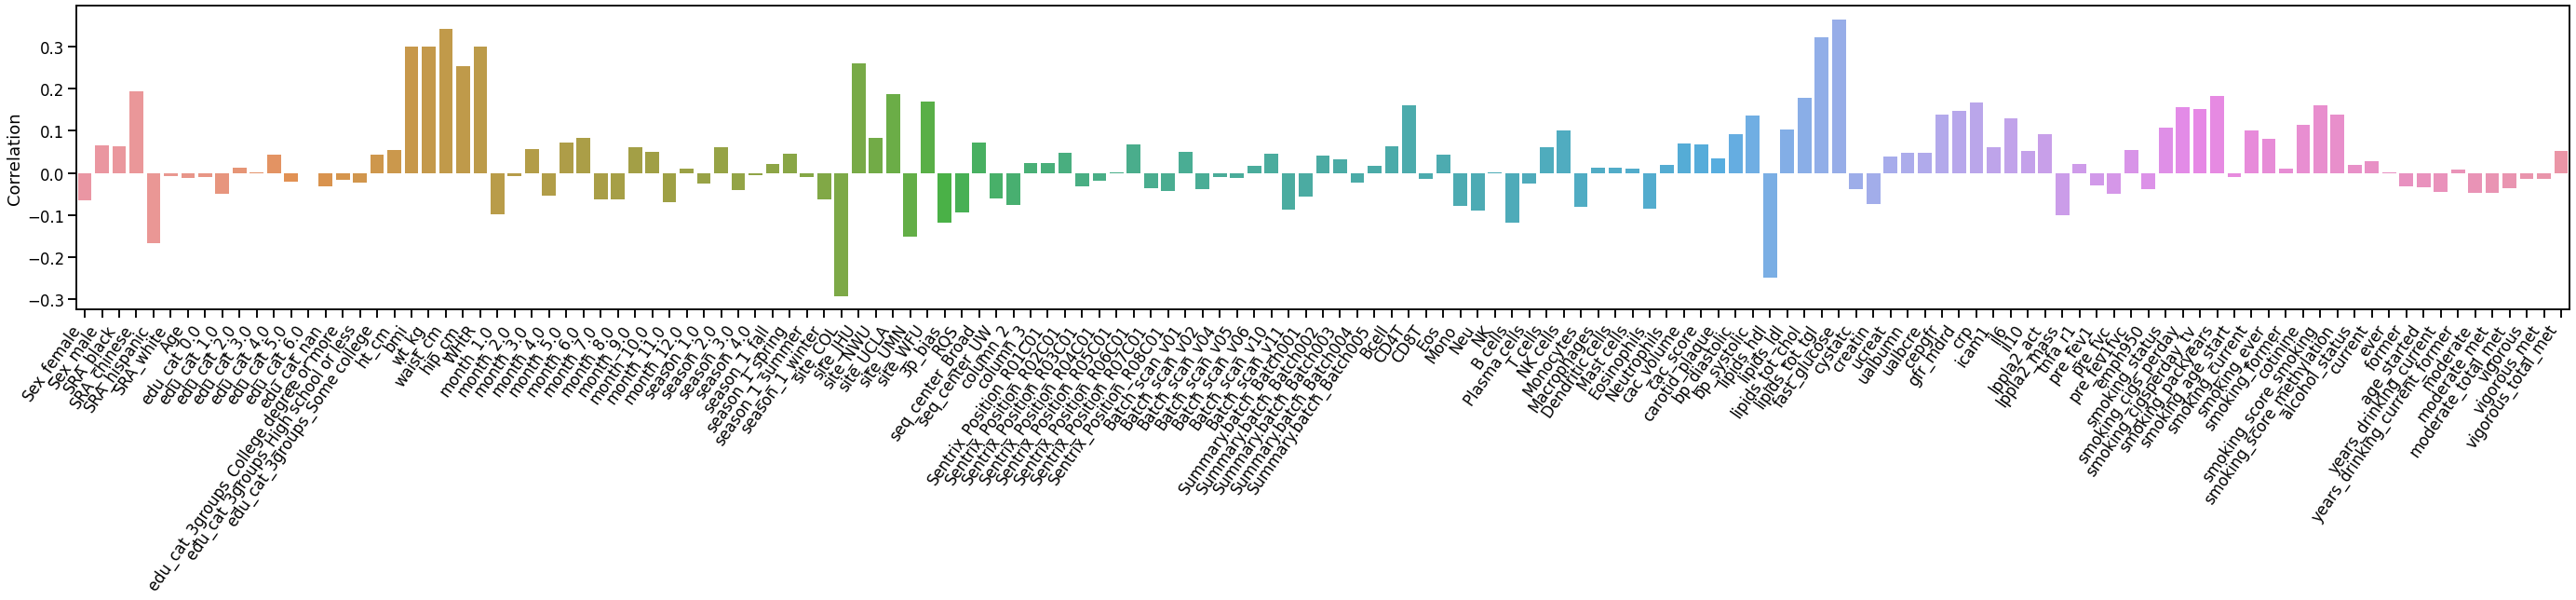

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(48, 6))
factor_cor_data = cor_data_1.loc['Z6']
ax = sns.barplot(x=factor_cor_data.index, y = factor_cor_data)
ax.set(ylabel='Correlation')
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=55, horizontalalignment='right')

(-0.42, 0.42)

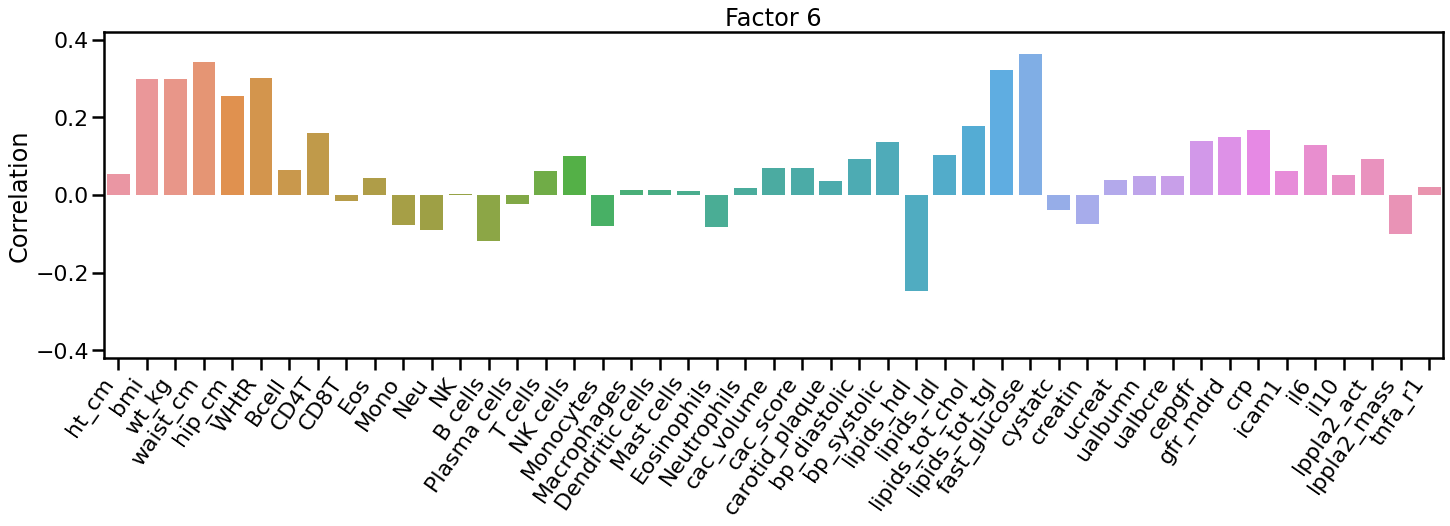

In [ ]:
sns.set_context('poster')
plt.figure(figsize=(24, 6))
factor_cor_data = cor_data_1.loc['Z6']
factor_cor_data = pd.concat([factor_cor_data[18:24], factor_cor_data[76:117]])
ax = sns.barplot(x=factor_cor_data.index, y = factor_cor_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=55, horizontalalignment='right')
ax.set(ylabel='Correlation', title='Factor 6')
ax.set_ylim(-0.42, 0.42)

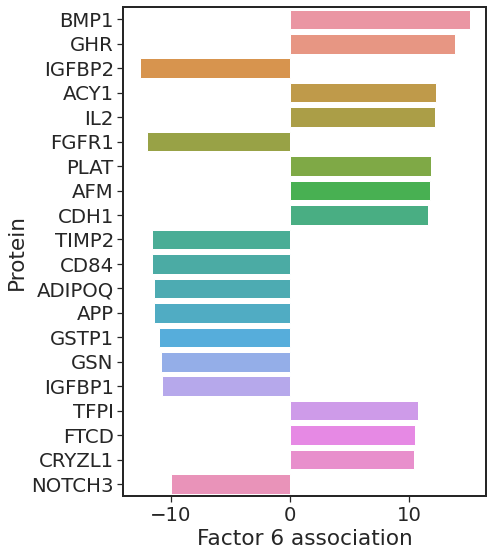

In [ ]:
sns.set(font_scale=1.8, style='ticks', rc={"axes.linewidth": 2})
plt.figure(figsize=(6.5, 9))
prot_scores_names['5abs'] = abs(prot_scores_names[5])
selected = prot_scores_names[[5, '5abs']].sort_values(by='5abs', ascending=False)[0:20]
ax = sns.barplot(data=selected.reset_index(), x=5, y='index')
ax.set(xlabel='Factor 6 association', ylabel='Protein')
plt.show()

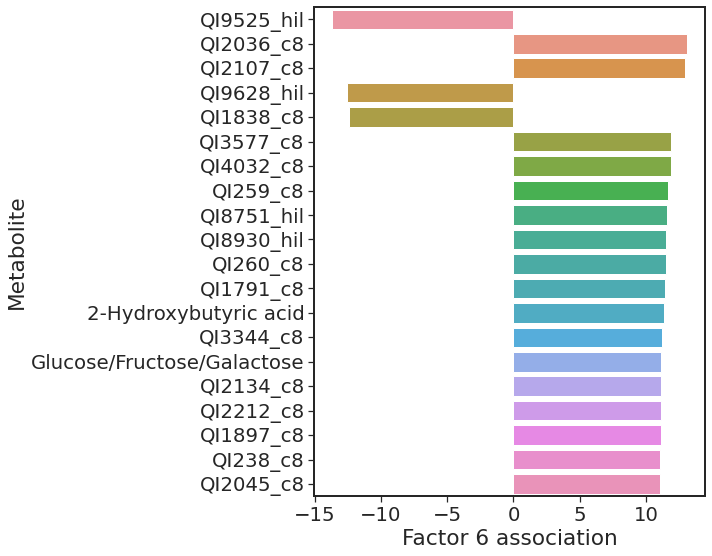

In [ ]:
metab_scores['5abs'] = abs(metab_scores[5])
sns.set(font_scale=1.8, style='ticks', rc={"axes.linewidth": 2})
plt.figure(figsize=(7, 9))
metab_scores['5abs'] = abs(metab_scores[5])
selected = metab_scores[[5, '5abs']].sort_values(by='5abs', ascending=False)[0:20]
ax = sns.barplot(data=selected.reset_index(), x=5, y='ID')
ax.set(xlabel='Factor 6 association', ylabel='Metabolite')
plt.show()

In [ ]:
dim_6_sumstats = pd.read_table(gwas_folder + 'sumstats/factors_exam1.gwas_pairs_maf05.Z_6.sumstats', index_col='SNP')
dim_6_sumstats['Chi2'] = dim_6_sumstats.Z**2
dim_6_sumstats['p_val'] = 1 - stats.chi2.cdf(dim_6_sumstats['Chi2'], df=1)
snp_factor_info_6 = teqtl_info.join(dim_6_sumstats, on='SNP').drop_duplicates(['rs ID', 'Trait'])
show_table_6 = snp_factor_info_6.loc[snp_factor_info_6['p_val'] < 0.01].sort_values(by='p_val')

In [ ]:
show_table_6['p_val'] = show_table_6['p_val'].apply(lambda x: round(x, 5))
show_table_6['Chr:Pos'] = show_table_6['Chr'].astype(str) + ":" + show_table_6['Position'].astype(str)

In [ ]:
show_table_6 = show_table_6.join(show_table_6.groupby('Trait')[['rs ID', 'p_val', 'Chr:Pos']].agg(list), on='Trait', rsuffix='(s)').sort_values(by='p_val').drop_duplicates('Trait')
show_table_6 = show_table_6.join(show_table_6.groupby('rs ID')[['Trait', 'PUBMED ID']].agg(list), on='rs ID', rsuffix='(s)').drop_duplicates('rs ID')
show_table_6['F6 p val(s)'] = show_table_6['p_val(s)']
show_table_6 = show_table_6[['Trait(s)', 'PUBMED ID(s)', 'rs ID(s)', 'Chr:Pos(s)', 'F6 p val(s)']]

In [ ]:
show_table_6[0:20]

Trait(s)  \
13767                                                                                      [Schizophrenia]   
1292                                                                    [Age-related macular degeneration]   
11007                                                                                           [Vitiligo]   
569                                             [Febrile seizures, Febrile seizures (MMR vaccine-related)]   
17178                                                                                 [Adiponectin levels]   
9132                                                                            [Menopause (age at onset)]   
16476                                                                               [Mature red cell;MCHC]   
2961                                                                                    [Refractive error]   
8673                                                                                        [Platelet;PDW]   
5160                                                                    [Alzheimer's disease (late onset)]   
886                                                                                [Common traits (Other)]   
17719               [Protein C levels, Coagulation factor levels, Factor VII levels, Anticoagulant levels]   
94                                                                                  [Mean platelet volume]   
16590                                                                            [Menarche (age at onset)]   
10686    [Homeostasis model assessment of insulin resistance (interaction), Fasting insulin (interaction)]   
3527                                                                                         [Neuroticism]   
10243                                                                         [Lymphoid white cell;LYMPH#]   
887                                                                                      [Hair morphology]   
218    [Bone mineral density (spine), Dupuytren's disease, Ulcerative colitis, Bone mineral density (hip)]   
16769                                                                                    [Prostate cancer]   

                                                  PUBMED ID(s)  \
13767                                               [26198764]   
1292                                                [15761122]   
11007                                [Curated from Immunobase]   
569                                       [25344690, 25344690]   
17178                                               [22479202]   
9132                                                [22267201]   
16476                                               [27863252]   
2961                                                [23396134]   
8673                                                [27863252]   
5160                                                [26339675]   
886                                                 [20585627]   
17719                 [25376901, 20231535, 20231535, 22216198]   
94                                                  [27863252]   
16590                                               [25231870]   
10686                                     [24204828, 24204828]   
3527                                                [25993607]   
10243                                               [27863252]   
887                                                 [19896111]   
218    [19801982, 21732829, Curated from Immunobase, 19079262]   
16769                                               [23535732]   

                                                                                  rs ID(s)  \
13767  [rs112973353, rs11874716, rs4801131, rs12966547, rs10425465, rs11682175, rs4129585]   
1292                    [rs380390, rs1061147, rs1329428, rs10801555, rs1329424, rs1410996]   
11007                                                                          [rs3814231]   
569                     

In [ ]:
show_table_6.to_csv('/gpfs/commons/projects/MESA/projects/mpcca/table_factor_6.csv', index=False)

In [ ]:
# Comparison with a simple multi-modal auto-encoder
# Adapted from https://discuss.pytorch.org/t/an-autoencoder-with-multiple-inputs/139138

class MMAE(torch.nn.Module):
  def __init__(self, input_dims, pc_dims, cc_dim):
    super().__init__()
    self.encoders = torch.nn.ModuleList()
    self.decoders = torch.nn.ModuleList()
    self.pc_dims = pc_dims

    for in_dim, pc_dim in zip(input_dims, pc_dims):
      self.encoders.append(
          torch.nn.Sequential(
              torch.nn.Linear(in_dim, 8*pc_dim),
              torch.nn.ReLU(),
              torch.nn.Linear(8*pc_dim, pc_dim),
              torch.nn.ReLU()))

    for in_dim, pc_dim in zip(input_dims, pc_dims):
      self.decoders.append(
          torch.nn.Sequential(
              torch.nn.Linear(pc_dim, 8*pc_dim),
              torch.nn.ReLU(),
              torch.nn.Linear(8*pc_dim,in_dim)))

    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(sum(pc_dims), 8*cc_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(8*cc_dim, cc_dim))
 
    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(cc_dim, 8*cc_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(8*cc_dim, sum(pc_dims)),
        torch.nn.ReLU())
    
  def encode(self, datasets):
    out = []
    for idx, enc in enumerate(self.encoders):
      out.append(enc(datasets[idx]))
    out = torch.cat(out, dim=1)
    z = self.encoder(out)
    return z
  
  def decode(self, z):
    out = self.decoder(z)
    out = torch.split(out, self.pc_dims, dim=1)
    outs = []
    for idx, dec in enumerate(self.decoders):
      outs.append(dec(out[idx]))
    return outs    

  def forward(self, datasets):
    z = self.encode(datasets)
    outs = self.decode(z)
    return outs

def normalized_MSE(pred, data):
  loss = 0
  for pred_i, data_i in zip(pred, data):
    loss +=  torch.mean((pred_i - data_i)**2)
  return loss/len(pred)

In [ ]:
data_tensors = [torch.from_numpy(v.values).float() for _, v in Y.items()]
ae_model = MMAE([v.shape[1] for k, v in Y.items()], mcfa_res.n_pcs, mcfa_res.d)
optimizer = torch.optim.Adagrad(ae_model.parameters())

ae_model.train()

total_loss = 0
total_loss_old = float('inf')
n_splits = 10
n_epochs = 1000
batches = model_selection.RepeatedKFold(n_splits=n_splits, n_repeats=n_epochs)
t = time.time()
for it, (_, index) in enumerate(batches.split(data_tensors[0])):
  data = [dt[index] for dt in data_tensors]
  pred = ae_model(data)
  loss = normalized_MSE(pred, data)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  total_loss += loss
  perc = torch.tensor(np.nan)

  if (it+1)%n_splits == 0:
    total_loss = total_loss/n_splits
    delta = total_loss_old - total_loss
    perc = delta/total_loss_old
    print("Epoch :", int((it+1)/n_splits), "Loss:", total_loss.item(), "Delta:", delta.item(), "Pecentage:", perc.item(), "Time (m):", (time.time() - t)/60)
    total_loss_old = total_loss
    total_loss = 0
  if ~np.isnan(perc.item()) & (abs(perc.item()) < 0.000001):
    break

Epoch : 1 Loss: 13.485644340515137 Delta: inf Pecentage: nan Time (m): 0.2630465308825175
Epoch : 2 Loss: 0.9737818837165833 Delta: 12.511862754821777 Pecentage: 0.9277912378311157 Time (m): 0.4316709597905477
Epoch : 3 Loss: 0.9490107297897339 Delta: 0.024771153926849365 Pecentage: 0.025438092648983 Time (m): 0.5837749123573304
Epoch : 4 Loss: 0.935764491558075 Delta: 0.013246238231658936 Pecentage: 0.013957943767309189 Time (m): 0.7487255175908406
Epoch : 5 Loss: 0.9230449795722961 Delta: 0.012719511985778809 Pecentage: 0.013592642731964588 Time (m): 0.8659679810206096
Epoch : 6 Loss: 0.90483158826828 Delta: 0.018213391304016113 Pecentage: 0.019731856882572174 Time (m): 1.0028754949569703
Epoch : 7 Loss: 0.8876924514770508 Delta: 0.017139136791229248 Pecentage: 0.01894179731607437 Time (m): 1.140340526898702
Epoch : 8 Loss: 0.8679074048995972 Delta: 0.019785046577453613 Pecentage: 0.02228817716240883 Time (m): 1.2675905426343281
Epoch : 9 Loss: 0.8554571866989136 Delta: 0.01245021820

In [ ]:
Z_mmae = ae_model.encode(data_tensors)
Z_mmae = Z_mmae.detach().numpy()
Z_mmae = pd.DataFrame(Z_mmae, index=mcfa_res.Z.index, columns=mcfa_res.Z.columns)
Z_mmae.to_csv('/gpfs/commons/projects/MESA/projects/mpcca/mmae_factors_exam' + exam + '.csv')

In [7]:
Z_mmae = pd.read_csv('/gpfs/commons/projects/MESA/projects/mpcca/mmae_factors_exam' + exam + '.csv', index_col=0)

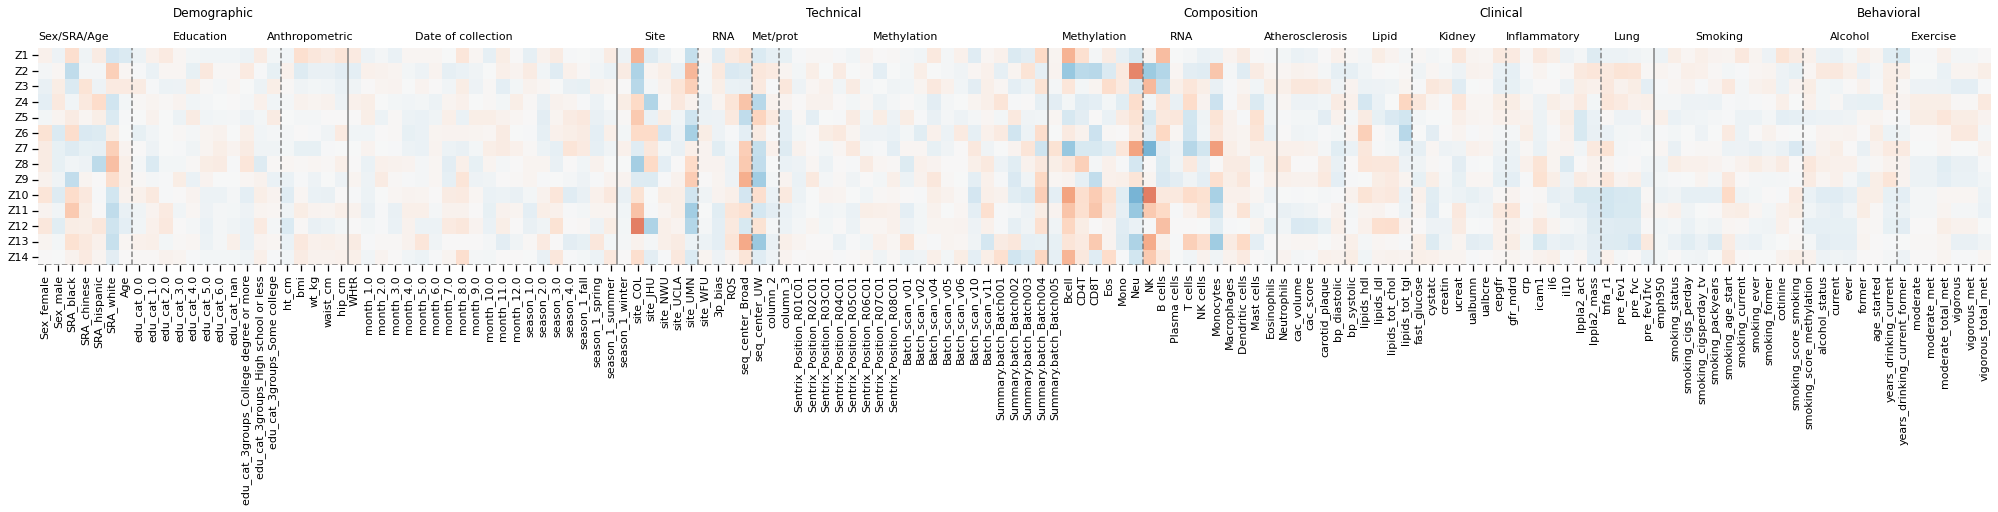

In [8]:
sns.set_context("notebook")
plt.figure(figsize=(35, 4))

order = pd.read_csv('/gpfs/commons/projects/MESA/projects/mpcca/MESA_phenotype_order_with_dummies.csv', index_col='Phenotype')
data_cols = Z_mmae.shape[1]
covariate_cols = meta_df_dummies[order.index].shape[1]
# cor_data_1 = abs(mcfa_res_df.join(meta_df_dummies[order.index]).corr().iloc[0:data_cols, data_cols:])
# ax = sns.heatmap(cor_data_1, vmin=0, vmax=1, cbar=None)
cor_data_1 = Z_mmae.join(meta_df_dummies[order.index]).corr().iloc[0:data_cols, data_cols:]
ax = sns.heatmap(cor_data_1, vmin=-1, vmax=1, center=0, cmap='RdBu_r', cbar=None)
ax.vlines([23, 43, 75, 92, 120], *ax.get_ylim(), colors='gray')
ax.vlines([7, 18, 49, 53, 55, 82, 97, 102, 109, 116, 131, 138], *ax.get_ylim(), colors='gray', linestyles='dashed')
ax.hlines([14, 30, 53, 66], *ax.get_xlim(), colors='gray', linestyles='dashed')
ax.text(10, -2, 'Demographic', fontsize=12)
ax.text(57, -2, 'Technical', fontsize=12)
ax.text(85, -2, 'Composition', fontsize=12)
ax.text(107, -2, 'Clinical', fontsize=12)
ax.text(135, -2, 'Behavioral', fontsize=12)
ax.text(0, -0.5, 'Sex/SRA/Age', fontsize=11)
ax.text(10, -0.5, 'Education', fontsize=11)
ax.text(17, -0.5, 'Anthropometric', fontsize=11)
ax.text(28, -0.5, 'Date of collection', fontsize=11)
ax.text(45, -0.5, 'Site', fontsize=11)
ax.text(50, -0.5, 'RNA', fontsize=11)
ax.text(53, -0.5, 'Met/prot', fontsize=11)
ax.text(62, -0.5, 'Methylation', fontsize=11)
ax.text(76, -0.5, 'Methylation', fontsize=11)
ax.text(84, -0.5, 'RNA', fontsize=11)
ax.text(91, -0.5, 'Atherosclerosis', fontsize=11)
ax.text(99, -0.5, 'Lipid', fontsize=11)
ax.text(104, -0.5, 'Kidney', fontsize=11)
ax.text(109, -0.5, 'Inflammatory', fontsize=11)
ax.text(117, -0.5, 'Lung', fontsize=11)
ax.text(123, -0.5, 'Smoking', fontsize=11)
ax.text(133, -0.5, 'Alcohol', fontsize=11)
ax.text(139, -0.5, 'Exercise', fontsize=11)
plt.show()

In [ ]:
abs(cor_data_1.loc['Z1']).idxmax()

'Neu'

In [ ]:
abs(cor_data_1.loc['Z2']).idxmax()

'seq_center_Broad'

In [ ]:
abs(cor_data_1.loc['Z3']).idxmax()

'Bcell'

In [ ]:
abs(cor_data_1.loc['Z4']).idxmax()

'Neu'

In [ ]:
abs(cor_data_1.loc['Z5']).idxmax()

'NK'

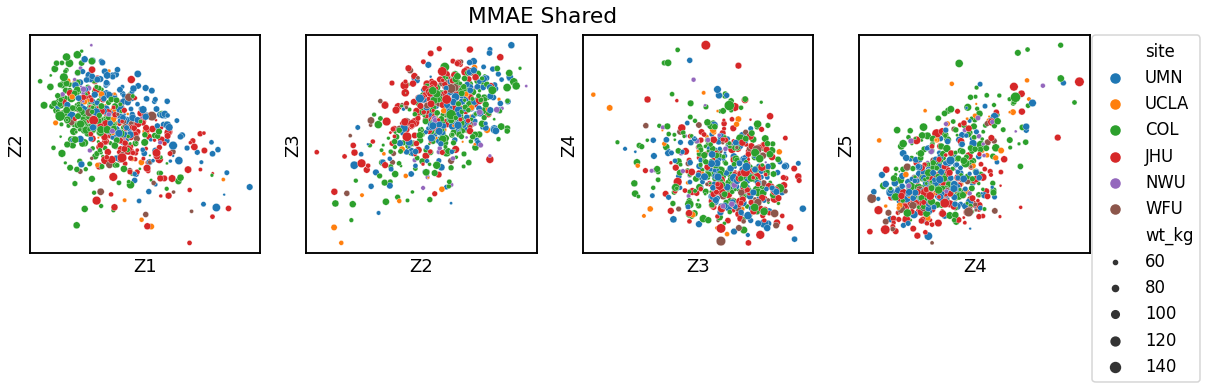

In [ ]:
sns.set_context('talk')
figure, axes = plt.subplots(1, 4, sharex=False, figsize=(19,4))
figure.suptitle('MMAE Shared')

for ax, x, y in zip(axes, ['Z1', 'Z2', 'Z3', 'Z4'], ['Z2', 'Z3', 'Z4', 'Z5']):
    # ax.set_title(x + ' vs ' + y)
    ax.set(xticklabels=[], yticklabels=[])
    ax.yaxis.labelpad = -8
    ax.xaxis.labelpad = -8
    ax.tick_params(bottom=False, left=False)
    sns.scatterplot(ax=ax, data=Z_mmae, x=x, y=y, sizes=(1,100),
                    hue=meta_df['site'], size=meta_df['wt_kg'],
                    legend=True if y=='Z5' else False)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0.)
figure.show()

In [ ]:
logistic_null = linear_model.LogisticRegression(penalty='none', max_iter=1000, fit_intercept=False)
logistic_fit = linear_model.LogisticRegression(penalty='none', max_iter=1000)
linear = linear_model.LinearRegression()

pred_res = {}
for col in meta_df.columns:
  mask = ~pd.isna(meta_df[col])
  if len(pd.unique(meta_df[col])) < 13:
    intercept = np.ones((sum(mask),1))
    null_model = logistic_null.fit(intercept, meta_df[col][mask])
    fit_model = logistic_fit.fit(Z_mmae[mask], meta_df[col][mask])
    null_ll = metrics.log_loss(meta_df[col][mask], null_model.predict_proba(intercept), normalize=False)
    fit_ll = metrics.log_loss(meta_df[col][mask], fit_model.predict_proba(Z_mmae[mask]), normalize=False)
    r2_score = 1.0 - fit_ll/null_ll
  else:
    fit_model = linear.fit(Z_mmae[mask], meta_df[col][mask])
    r2_score = fit_model.score(Z_mmae[mask], meta_df[col][mask])
  pred_res[col] = r2_score
pred_res_1 = pd.Series(pred_res, name='Z_mmae')

/gpfs/commons/home/bbrown/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/gpfs/commons/home/bbrown/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

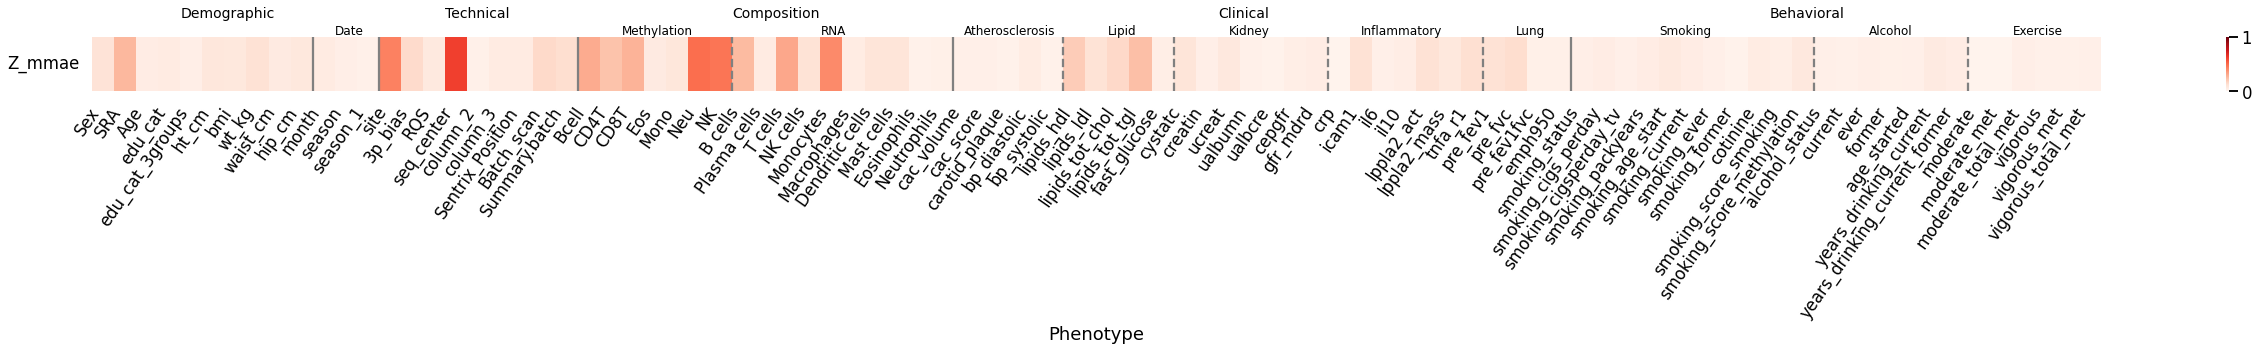

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(45, 1))

order = pd.read_csv('/gpfs/commons/projects/MESA/projects/mpcca/MESA_phenotype_order_normal.csv', index_col='Phenotype')
pred_res_1 = pred_res_1[order.index]
ax = sns.heatmap(pd.DataFrame(pred_res_1).T, vmin=0, vmax=1, cmap='Reds')
ax.set_xticklabels(ax.get_xticklabels(), rotation=55, horizontalalignment='right')
ax.set_yticklabels(["Z_mmae"], rotation=0)
ax.tick_params(bottom=False, left=False)

ax.vlines([10, 13, 22, 39, 67], *ax.get_ylim(), colors='gray')
# ax.vlines([3, 5, 14, 33, 48, 53, 60, 67, 82, 89], *ax.get_ylim(), colors='gray', linestyles='dashed')
ax.vlines([29, 44, 49, 56, 63, 78, 85], *ax.get_ylim(), colors='gray', linestyles='dashed')
ax.text(4, -0.35, 'Demographic', fontsize=14)
ax.text(16, -0.35, 'Technical', fontsize=14)
ax.text(29, -0.35, 'Composition', fontsize=14)
ax.text(51, -0.35, 'Clinical', fontsize=14)
ax.text(76, -0.35, 'Behavioral', fontsize=14)
# ax.text(0, -0.5, 'Sex/Race/Age', fontsize=11)
# ax.text(10, -0.5, 'Education', fontsize=11)
# ax.text(17, -0.5, 'Anthropometric', fontsize=11)
ax.text(11, -0.05, 'Date', fontsize=12)
# ax.text(49, -0.5, 'Site', fontsize=11)
# ax.text(54, -0.5, 'RNA', fontsize=11)
# ax.text(57, -0.5, 'Met/prot', fontsize=11)
# ax.text(66, -0.5, 'Methylation', fontsize=11)
ax.text(24, -0.05, 'Methylation', fontsize=12)
ax.text(33, -0.05, 'RNA', fontsize=12)
ax.text(39.5, -0.05, 'Atherosclerosis', fontsize=12)
ax.text(46, -0.05, 'Lipid', fontsize=12)
ax.text(51.5, -0.05, 'Kidney', fontsize=12)
ax.text(57.5, -0.05, 'Inflammatory', fontsize=12)
ax.text(64.5, -0.05, 'Lung', fontsize=12)
ax.text(71, -0.05, 'Smoking', fontsize=12)
ax.text(80.5, -0.05, 'Alcohol', fontsize=12)
ax.text(87, -0.05, 'Exercise', fontsize=12)
plt.show()

In [ ]:
pred_res_1.sort_values()

Phenotype
smoking_former        0.012390
moderate_total_met    0.022326
smoking_ever          0.022332
moderate              0.024585
moderate_met          0.024585
                        ...   
O3                    0.423743
site                  0.442244
NK                    0.516934
seq_center            0.612376
Neu                   0.632469
Name: Z_mmae, Length: 95, dtype: float64

In [ ]:
Z = preprocessing.StandardScaler().fit_transform(Z_mmae)
embedding_Z = umap.UMAP().fit_transform(Z)

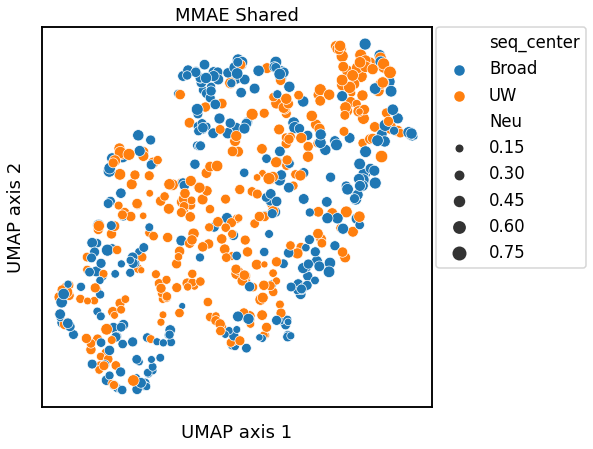

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(7, 7))
ax = sns.scatterplot(data=pd.DataFrame(embedding_Z, columns=['Ax1', 'Ax2'], index=mcfa_res.Z.index), x='Ax1', y='Ax2', hue=meta_df['seq_center'], size=meta_df['Neu'])
ax.set(xlabel='UMAP axis 1', ylabel='UMAP axis 2', title='MMAE Shared')
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0.)
plt.show()

In [ ]:
# Quickly trying MOFA2
from mofapy2.run.entry_point import entry_point

In [ ]:
import mofapy2

In [ ]:
mofapy2.__version__

'0.6.7'

In [ ]:
data_mofa = [[v.values] for _, v in Y.items()]
views_names = [k for k, _ in Y.items()]
samples_names = [Y['exp'].index.values]
features_names = [[val + '_' + k for val in v.columns.values] for k, v in Y.items()]

ent = entry_point()
ent.set_data_options(scale_groups = False, scale_views = False)
ent.set_data_matrix(data_mofa, views_names=views_names,
                    samples_names=samples_names, features_names=features_names)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
use_float32 set to True: replacing float64 arrays by float32 arrays to speed up computations...

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Successfully loaded view='exp' group='group0' with N=614 samples and D=19034 features...
Successfully loaded view='methyl' group='group0' with N=614 samples and D=724210 features...
Successfull

In [ ]:
ent.set_model_options(factors = mcfa_res.d, ard_weights = True, spikeslab_weights = True)
ent.set_train_options(iter=1000, convergence_mode='medium')

Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (exp): gaussian
- View 1 (methyl): gaussian
- View 2 (prot): gaussian
- View 3 (metab): gaussian




In [ ]:
ent.build()
ent.run()



######################################
## Training the model with seed 541782 ##
######################################


ELBO before training: -4375986641.25 

Iteration 1: time=51.70, ELBO=-600820838.16, deltaELBO=3775165803.088 (86.27004862%), Factors=14
Iteration 2: time=49.37, ELBO=-538940247.63, deltaELBO=61880590.533 (1.41409459%), Factors=14
Iteration 3: time=49.69, ELBO=-535141309.44, deltaELBO=3798938.186 (0.08681329%), Factors=14
Iteration 4: time=48.47, ELBO=-532873789.68, deltaELBO=2267519.761 (0.05181734%), Factors=14
Iteration 5: time=48.41, ELBO=-530958513.10, deltaELBO=1915276.580 (0.04376788%), Factors=14
Iteration 6: time=48.23, ELBO=-529422475.73, deltaELBO=1536037.375 (0.03510151%), Factors=14
Iteration 7: time=49.43, ELBO=-528206882.40, deltaELBO=1215593.330 (0.02777873%), Factors=14
Iteration 8: time=49.86, ELBO=-527246123.31, deltaELBO=960759.087 (0.02195526%), Factors=14
Iteration 9: time=52.27, ELBO=-526521656.03, deltaELBO=724467.277 (0.01655552%), Factors=

In [ ]:
Z_mofa = pd.DataFrame(ent.model.getParameters()['Z']['mean'], index=mcfa_res.Z.index, columns=['Z' + str(i) for i in range(1, mcfa_res.d+1)])

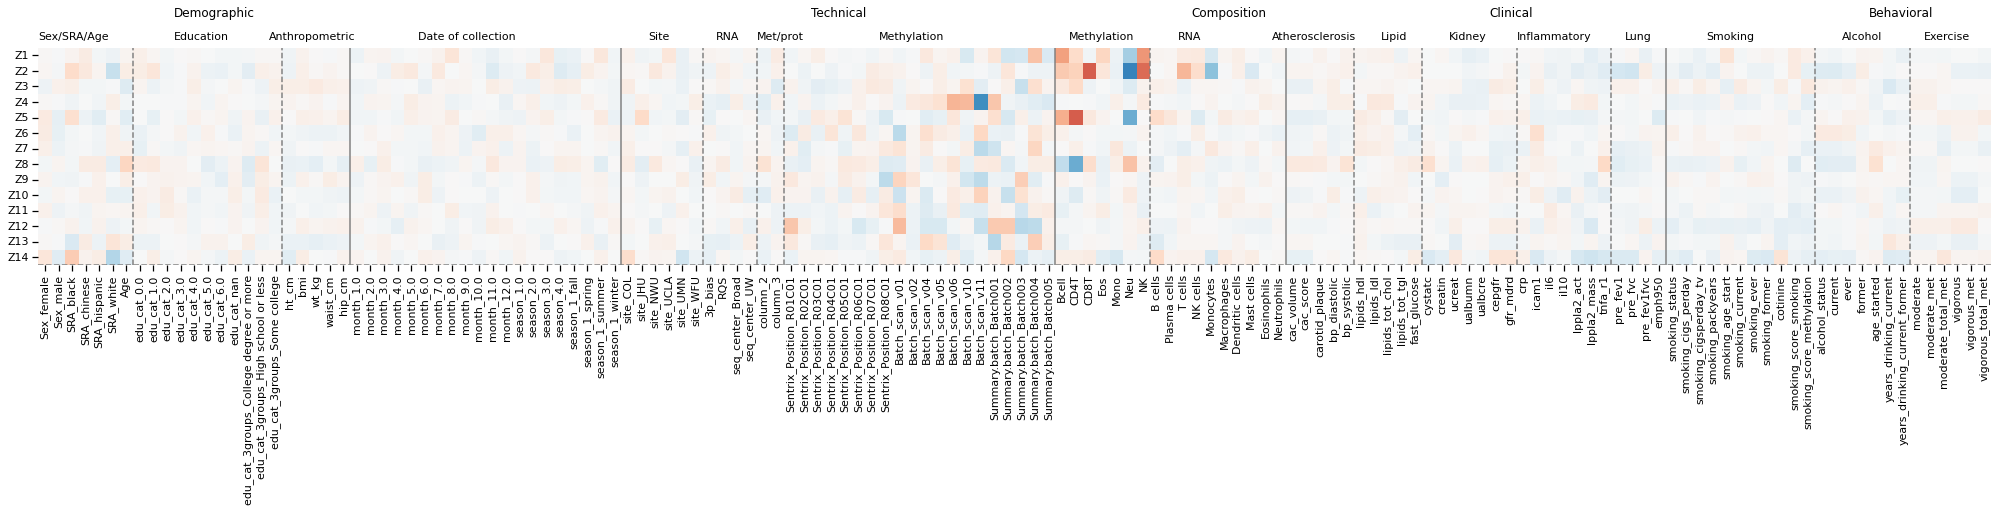

In [ ]:
sns.set_context("notebook")
plt.figure(figsize=(35, 4))

order = pd.read_csv('/gpfs/commons/projects/MESA/projects/mpcca/MESA_phenotype_order_with_dummies.csv', index_col='Phenotype')
data_cols = Z_mofa.shape[1]
covariate_cols = meta_df_dummies[order.index].shape[1]
# cor_data_1 = abs(mcfa_res_df.join(meta_df_dummies[order.index]).corr().iloc[0:data_cols, data_cols:])
# ax = sns.heatmap(cor_data_1, vmin=0, vmax=1, cbar=None)
cor_data_1 = Z_mofa.join(meta_df_dummies[order.index]).corr().iloc[0:data_cols, data_cols:]
ax = sns.heatmap(cor_data_1, vmin=-1, vmax=1, center=0, cmap='RdBu_r', cbar=None)
ax.vlines([23, 43, 75, 92, 120], *ax.get_ylim(), colors='gray')
ax.vlines([7, 18, 49, 53, 55, 82, 97, 102, 109, 116, 131, 138], *ax.get_ylim(), colors='gray', linestyles='dashed')
ax.hlines([14, 30, 53, 66], *ax.get_xlim(), colors='gray', linestyles='dashed')
ax.text(10, -2, 'Demographic', fontsize=12)
ax.text(57, -2, 'Technical', fontsize=12)
ax.text(85, -2, 'Composition', fontsize=12)
ax.text(107, -2, 'Clinical', fontsize=12)
ax.text(135, -2, 'Behavioral', fontsize=12)
ax.text(0, -0.5, 'Sex/SRA/Age', fontsize=11)
ax.text(10, -0.5, 'Education', fontsize=11)
ax.text(17, -0.5, 'Anthropometric', fontsize=11)
ax.text(28, -0.5, 'Date of collection', fontsize=11)
ax.text(45, -0.5, 'Site', fontsize=11)
ax.text(50, -0.5, 'RNA', fontsize=11)
ax.text(53, -0.5, 'Met/prot', fontsize=11)
ax.text(62, -0.5, 'Methylation', fontsize=11)
ax.text(76, -0.5, 'Methylation', fontsize=11)
ax.text(84, -0.5, 'RNA', fontsize=11)
ax.text(91, -0.5, 'Atherosclerosis', fontsize=11)
ax.text(99, -0.5, 'Lipid', fontsize=11)
ax.text(104, -0.5, 'Kidney', fontsize=11)
ax.text(109, -0.5, 'Inflammatory', fontsize=11)
ax.text(117, -0.5, 'Lung', fontsize=11)
ax.text(123, -0.5, 'Smoking', fontsize=11)
ax.text(133, -0.5, 'Alcohol', fontsize=11)
ax.text(139, -0.5, 'Exercise', fontsize=11)
plt.show()

In [ ]:
abs(cor_data_1.loc['Z1']).idxmax()

'NK'

In [ ]:
abs(cor_data_1.loc['Z2']).idxmax()

'Neu'

In [ ]:
abs(cor_data_1.loc['Z3']).idxmax()

'Summary.batch_Batch003'

In [ ]:
abs(cor_data_1.loc['Z4']).idxmax()

'Batch_scan_v11'

In [ ]:
abs(cor_data_1.loc['Z5']).idxmax()

'CD4T'

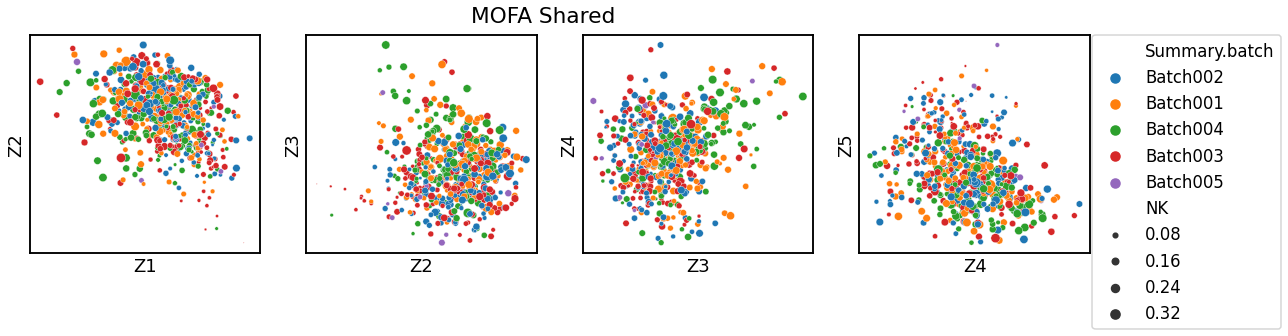

In [ ]:
sns.set_context('talk')
figure, axes = plt.subplots(1, 4, sharex=False, figsize=(19,4))
figure.suptitle('MOFA Shared')

for ax, x, y in zip(axes, ['Z1', 'Z2', 'Z3', 'Z4'], ['Z2', 'Z3', 'Z4', 'Z5']):
    # ax.set_title(x + ' vs ' + y)
    ax.set(xticklabels=[], yticklabels=[])
    ax.yaxis.labelpad = -8
    ax.xaxis.labelpad = -8
    ax.tick_params(bottom=False, left=False)
    sns.scatterplot(ax=ax, data=Z_mmae, x=x, y=y, sizes=(1,100),
                    hue=meta_df['Summary.batch'], size=meta_df['NK'],
                    legend=True if y=='Z5' else False)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0.)
figure.show()

In [ ]:
logistic_null = linear_model.LogisticRegression(penalty='none', max_iter=1000, fit_intercept=False)
logistic_fit = linear_model.LogisticRegression(penalty='none', max_iter=1000)
linear = linear_model.LinearRegression()

pred_res = {}
for col in meta_df.columns:
  mask = ~pd.isna(meta_df[col])
  if len(pd.unique(meta_df[col])) < 13:
    intercept = np.ones((sum(mask),1))
    null_model = logistic_null.fit(intercept, meta_df[col][mask])
    fit_model = logistic_fit.fit(Z_mofa[mask], meta_df[col][mask])
    null_ll = metrics.log_loss(meta_df[col][mask], null_model.predict_proba(intercept), normalize=False)
    fit_ll = metrics.log_loss(meta_df[col][mask], fit_model.predict_proba(Z_mofa[mask]), normalize=False)
    r2_score = 1.0 - fit_ll/null_ll
  else:
    fit_model = linear.fit(Z_mofa[mask], meta_df[col][mask])
    r2_score = fit_model.score(Z_mofa[mask], meta_df[col][mask])
  pred_res[col] = r2_score
pred_res_1 = pd.Series(pred_res, name='Z_mofa')

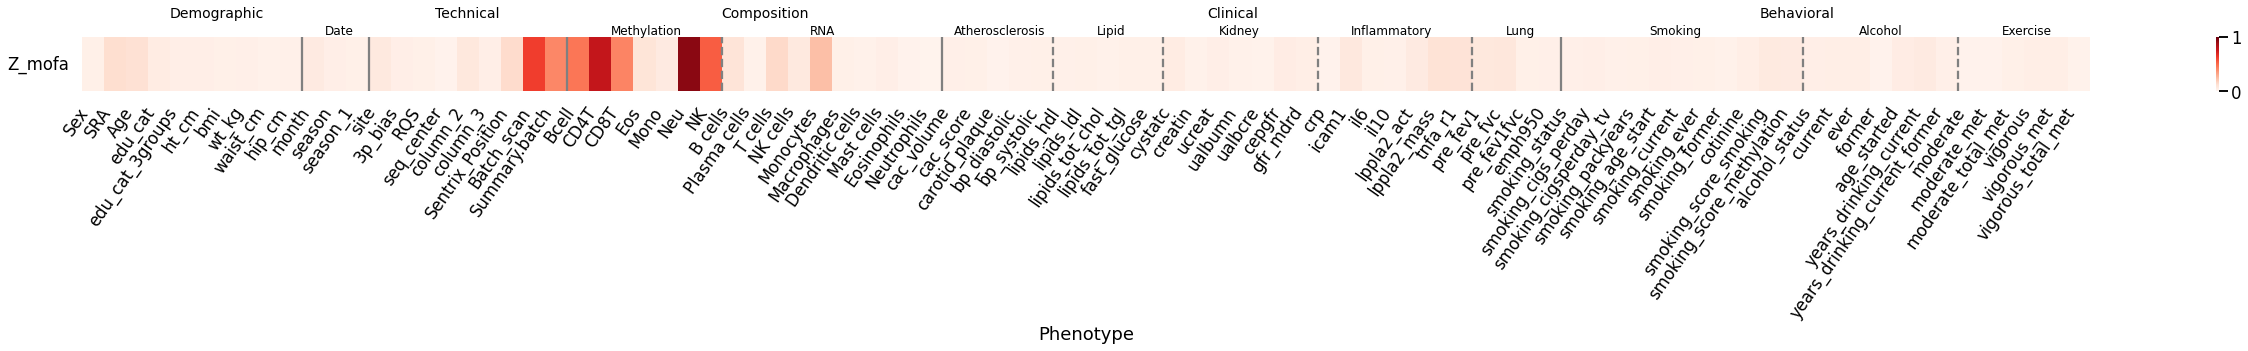

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(45, 1))

order = pd.read_csv('/gpfs/commons/projects/MESA/projects/mpcca/MESA_phenotype_order_normal.csv', index_col='Phenotype')
pred_res_1 = pred_res_1[order.index]
ax = sns.heatmap(pd.DataFrame(pred_res_1).T, vmin=0, vmax=1, cmap='Reds')
ax.set_xticklabels(ax.get_xticklabels(), rotation=55, horizontalalignment='right')
ax.set_yticklabels(["Z_mofa"], rotation=0)
ax.tick_params(bottom=False, left=False)

ax.vlines([10, 13, 22, 39, 67], *ax.get_ylim(), colors='gray')
# ax.vlines([3, 5, 14, 33, 48, 53, 60, 67, 82, 89], *ax.get_ylim(), colors='gray', linestyles='dashed')
ax.vlines([29, 44, 49, 56, 63, 78, 85], *ax.get_ylim(), colors='gray', linestyles='dashed')
ax.text(4, -0.35, 'Demographic', fontsize=14)
ax.text(16, -0.35, 'Technical', fontsize=14)
ax.text(29, -0.35, 'Composition', fontsize=14)
ax.text(51, -0.35, 'Clinical', fontsize=14)
ax.text(76, -0.35, 'Behavioral', fontsize=14)
# ax.text(0, -0.5, 'Sex/Race/Age', fontsize=11)
# ax.text(10, -0.5, 'Education', fontsize=11)
# ax.text(17, -0.5, 'Anthropometric', fontsize=11)
ax.text(11, -0.05, 'Date', fontsize=12)
# ax.text(49, -0.5, 'Site', fontsize=11)
# ax.text(54, -0.5, 'RNA', fontsize=11)
# ax.text(57, -0.5, 'Met/prot', fontsize=11)
# ax.text(66, -0.5, 'Methylation', fontsize=11)
ax.text(24, -0.05, 'Methylation', fontsize=12)
ax.text(33, -0.05, 'RNA', fontsize=12)
ax.text(39.5, -0.05, 'Atherosclerosis', fontsize=12)
ax.text(46, -0.05, 'Lipid', fontsize=12)
ax.text(51.5, -0.05, 'Kidney', fontsize=12)
ax.text(57.5, -0.05, 'Inflammatory', fontsize=12)
ax.text(64.5, -0.05, 'Lung', fontsize=12)
ax.text(71, -0.05, 'Smoking', fontsize=12)
ax.text(80.5, -0.05, 'Alcohol', fontsize=12)
ax.text(87, -0.05, 'Exercise', fontsize=12)
plt.show()

In [ ]:
pred_res_1.sort_values()

Phenotype
Neutrophils       0.012898
Eosinophils       0.015809
carotid_plaque    0.017174
moderate_met      0.017267
moderate          0.017267
                    ...   
Bcell             0.461442
NK                0.534739
Batch_scan        0.619162
CD4T              0.774096
Neu               0.929619
Name: Z_mofa, Length: 91, dtype: float64

In [ ]:
Z = preprocessing.StandardScaler().fit_transform(Z_mofa)
embedding_Z = umap.UMAP().fit_transform(Z)

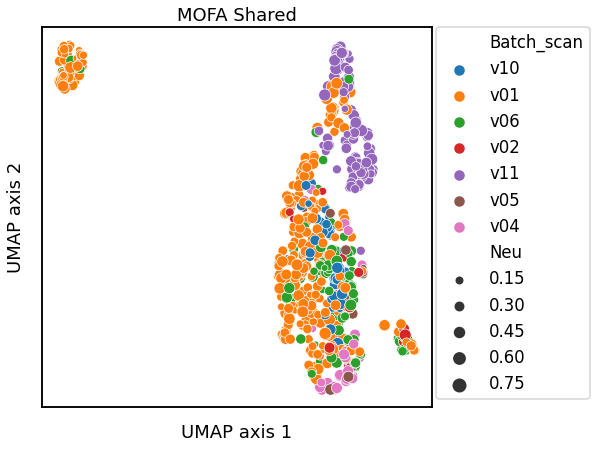

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(7, 7))
ax = sns.scatterplot(data=pd.DataFrame(embedding_Z, columns=['Ax1', 'Ax2'], index=mcfa_res.Z.index), x='Ax1', y='Ax2', hue=meta_df['Batch_scan'], size=meta_df['Neu'])
ax.set(xlabel='UMAP axis 1', ylabel='UMAP axis 2', title='MOFA Shared')
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0.)
plt.show()